# Imports

In [136]:
!which jupyter
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import re
from scipy.stats import mode as mode
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
pd.set_option('display.max_columns', 100)

/home/ubuntu/thesis_env2/bin/jupyter


In [2]:
# NER File
df_ner = pd.read_pickle('./data/df_ner_matched_210913.pickle')
print(len(df_ner))

# Sentiment Analysis
df_sent = pd.read_pickle('./data/df_sentiment.pickle')
df_sent['finbert'] = df_sent['finbert'].str.upper()

# measure of if all sentiment agree
sentiment_match = np.array(df_sent[['finbert', 'distilbert', 'roberta']])
sentiment_match = np.all(np.equal(sentiment_match, sentiment_match[:,:1]), axis=1)
df_sent['sentiment_match'] = sentiment_match

# most common sentiment
df_sent['sentiment'] = df_sent.apply(lambda x: mode([x['distilbert'], x['finbert'], x['roberta']])[0][0], axis=1)
print(len(df_sent))

# Topics
df_topics = pd.read_pickle("./data/df_with_topics")
df_topics['topic_label_str'] = ['_'.join(map(str, l)) for l in df_topics['topic_label']]
print(len(df_topics))

# Topics - manual defined topics
df_topics_manual = pd.read_pickle('df_doc_embeddings_word_additional.pickle')
print(len(df_topics_manual))

369045
365200
365200
365200


In [3]:
df_ner.head(1)

,author,date,domain,title,url,content,topic_area,org_names,filtered_names,filtered_names_match,filtered_names_titles_match
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,"[BA, Boeing, CAT, CMI, Caterpillar, Cummins In...","[Boeing, Caterpillar, Cummins Inc, Deere & Com...","[Caterpillar Inc., Cummins Inc., Deere & Compa...",[]


In [4]:
df_sent.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE


In [5]:
df_topics.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating,topic_words,primary_topic,secondary_topics,topic_label_str
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,970,,0.437342,low,"[caterpillar, ibe, fourthquarter, secondquarte...",,,


In [6]:
df_topics_manual.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0.692542,0.646232,0.677501,0.625921


In [7]:
df_topics_manual.columns

Index(['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain',
       'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure',
       'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain',
       'shutdown', 'outsourcing', 'workfromhome', 'diversification',
       'blockchain_word', 'digitization_word', 'machine_learne_word',
       'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word',
       'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
       'shutdown_word', 'outsourcing_word', 'workfromhome_word',
       'diversification_word', 'vaccines_word', 'drug_discovery_word',
       'tele_health_word', 'cybersecurity_word'],
      dtype='object')

In [50]:
df_combined = pd.merge(df_sent, df_topics[['topic_id', 'topic_label', 'topic_label_str', 'topic_score', 'topic_words', 'primary_topic']], how='left', left_index=True, right_index=True)
df_combined = pd.merge(df_combined, df_ner[['filtered_names_match', 'filtered_names_titles_match']], how='left', left_index=True, right_index=True)
df_combined['nb_companies'] = df_combined['filtered_names_match'].apply(lambda x: len(x))
df_combined['nb_companies_title'] = df_combined['filtered_names_titles_match'].apply(lambda x: len(x))
df_combined = pd.merge(df_combined, df_topics_manual[['blockchain', 'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure', 'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain', 'shutdown', 'outsourcing', 'workfromhome', 'diversification',
                                                     'blockchain_word', 'digitization_word', 'machine_learne_word', 'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word', 'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
                                                     'shutdown_word', 'outsourcing_word', 'workfromhome_word','diversification_word', 'vaccines_word', 'drug_discovery_word', 'tele_health_word', 'cybersecurity_word']], 
                       how='left', left_index=True, right_index=True)
df_combined = df_combined[df_combined['sentiment'] != ""]
df_combined = df_combined[df_combined['sentiment'] != 'too_long']
df_combined['month'] = df_combined['date'].dt.month
print(len(df_combined[df_combined['topic_label_str'] != ""]))

304898


In [51]:
df_combined.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word,month
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,"[Caterpillar Inc., Cummins Inc., Deere & Compa...",[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0.692542,0.646232,0.677501,0.625921,1


# Companies in articles

In [52]:
# List of all companies in filterned_names_match
companies = [comp for sublist in df_ner['filtered_names_match'].tolist() for comp in sublist]
#list(filter(lambda x: "Wesfarmers" in x, companies))

In [53]:
from collections import Counter
companies_count = Counter(companies)
companies_count = pd.DataFrame.from_dict(companies_count, orient='index', columns=['count']).reset_index()
companies_count.columns = ['company', 'count']
print(len(companies_count))
companies_count.head(1)

9704


,company,count
0,Caterpillar Inc.,526


In [54]:
companies_count[companies_count['company'].str.lower().str.contains('astra')]

,company,count
156,AstraZeneca PLC,3875


In [55]:
companies_count.sort_values(by='count', ascending=False)

,company,count
138,American International Holdings Corp.,19192
12,"Nasdaq, Inc.",12152
125,Treasury Metals Inc.,11742
63,Apple Inc.,9132
9,The New York Times Company,7181
...,...,...
8569,Geopacific Resources Limited,1
7116,Virginia Community Bankshares Inc.,1
7770,Oramed Pharmaceuticals Inc.,1
4903,Centaur Media Plc,1


# Load Company Data

In [56]:
def load_listed_companies(file_path, sheet_name, countries):

    companies_list = pd.read_excel(file_path, sheet_name = sheet_name)

    # Drop companies names that are 2 or 3 characters long
    companies_list = companies_list.drop(labels = companies_list[companies_list['name'].str.len() < 4].index)

    # Countries of interest
    companies_list = companies_list[companies_list['country'].isin(countries)]
    
    return companies_list

In [57]:
# Import listed companies
filepath_companies = './data/ner/company_names_listed.xlsx'
sheet_name = 'company_names'
countries_included = ['United States', 'Canada', 'Australia', 'United Kingdom']

companies_list = load_listed_companies(filepath_companies, sheet_name, countries_included)
companies_list.loc[companies_list[companies_list['name'] == 'Capstone Turbine Corporation'].index.values[0],'ticker_symbol'] = 'CGRN' # now known as Capstone Green Energy and historical prices are found under new name and code

comp_ind_dict = dict(zip(companies_list['name'], companies_list['industry']))
comp_subind_dict = dict(zip(companies_list['name'], companies_list['subindustry']))
comp_ticker_dict = dict(zip(companies_list['name'], companies_list['ticker_symbol']))
comp_country_dict = dict(zip(companies_list['name'], companies_list['country']))
ticker_ind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))
ticker_subind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))


print(companies_list['country'].value_counts())
print(len(companies_list))

United States     8848
Canada            3405
Australia         1873
United Kingdom    1424
Name: country, dtype: int64
15550


In [58]:
df_comp = df_combined.explode('filtered_names_match')
df_comp['industry'] = df_comp['filtered_names_match'].map(comp_ind_dict)
df_comp['subindustry'] = df_comp['filtered_names_match'].map(comp_subind_dict)
df_comp['ticker_symbol'] = df_comp['filtered_names_match'].map(comp_ticker_dict)
df_comp['country'] = df_comp['filtered_names_match'].map(comp_country_dict)

# Drop known problematic company names - names made up of very common company name words have very high false positive rate
comp_drop = ['Corporate Office Properties Trust', 'American International Holdings Corp.', 'First State Financial Corporation', 'The National Security Group, Inc.', 'The New York Times Company', 'Oxford Bank Corporation', 'SPX Corporation']
df_comp = df_comp[~df_comp['filtered_names_match'].isin(comp_drop)]

In [59]:
# Number of companies per article
df_combined['nb_companies'].value_counts()

0     177717
1      96978
2      43928
3      20231
4      10614
5       5990
6       3718
7       2243
8       1327
9        730
10       461
11       294
12       233
13       146
14       117
15        97
16        56
17        47
18        43
19        21
20        19
21        15
24        10
23         7
25         7
27         7
40         6
32         5
26         5
22         5
31         4
34         3
36         3
29         3
33         2
28         2
37         2
30         2
42         2
54         2
50         1
75         1
70         1
57         1
51         1
46         1
47         1
35         1
44         1
39         1
38         1
79         1
Name: nb_companies, dtype: int64

### Calculate company relevance score
- When company in article title: score = 1
- Else 1 / number of companies mention in article text

In [60]:
def company_relvance_cacl(df_row):
    
    if not pd.isna(df_row['filtered_names_match']):
        if df_row['filtered_names_match'] in df_row['filtered_names_titles_match']:
            return 1
        else:
            return 1 / df_row['nb_companies']

tqdm.pandas()
df_comp['company_relevance'] = df_comp.progress_apply(company_relvance_cacl, axis=1)

100%|██████████| 538700/538700 [00:09<00:00, 53953.90it/s]


In [61]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word,month,industry,subindustry,ticker_symbol,country,company_relevance
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0.692542,0.646232,0.677501,0.625921,1,Industrials,Machinery,CAT,United States,0.2


In [62]:
companies_list

,id,name,common_names,ticker_symbol,country,industry,subindustry
0,35931,"The Ultimate Software Group, Inc.",NaN,ULTI,United States,Information Technology,Software
1,35908,"U.S. Personnel, Inc.",NaN,USPE,United States,Industrials,Professional Services
2,203152,e.Digital Corporation,NaN,EDIG,United States,Information Technology,"Technology Hardware, Storage and Peripherals"
3,300794,Rowan Companies plc,NaN,RDC,United States,Energy,Energy Equipment and Services
5,388503,"HopFed Bancorp, Inc.",NaN,HFBC,United States,Financials,Thrifts and Mortgage Finance
...,...,...,...,...,...,...,...
51259,new003,"Revolution Medicines, Inc.",NaN,RVMD,United States,Healthcare,Biotechnology
51260,new004,PG&E Corporation,Pacific Gas and Electric Co,PCG,United States,Utilities,Multi-Utilities
51261,new005,"Virgin Galactic Holdings, Inc.",NaN,SPCE,United States,Industrials,Aerospace and Defense
51262,new006,"Rocket Companies, Inc.",NaN,RKT,United States,Financials,Thrifts and Mortgage Finance


# Financial Data

### Alpha Vantage
- API limits too small to process all data, use YFinance for long calls

In [63]:
from alpha_vantage.timeseries import TimeSeries
av_key = '2U3MBQY8379TF36Z'
ts = TimeSeries(key=av_key, output_format='pandas')

In [64]:
#ts.get_symbol_search('AAP Inc')

In [65]:
def get_prices(comp_select):
    price_list = []
    ticker_symbol = []

    for comp in comp_select:
        _ticker_symbol = comp_ticker_dict[comp]
        _prices = ts.get_monthly(_ticker_symbol)[0]['4. close']
        ticker_symbol.append(_ticker_symbol)
        price_list.append(_prices)

    df_prices = pd.DataFrame(price_list)
    df_prices.index = ticker_symbol
    
    return df_prices

### Yahoo Finance

In [66]:
import yfinance as yf
import datetime
import pickle

In [67]:
# Yahoo Finance Stock Ticker Suffixes
australia = 'AX'
canada = 'TO'
canada = 'V'
uk = 'L'

companies_count['ticker'] = companies_count['company'].map(comp_ticker_dict)
companies_count['country'] = companies_count['company'].map(comp_country_dict)
companies_count.head(1)

,company,count,ticker,country
0,Caterpillar Inc.,526,CAT,United States


In [68]:
companies_count_us = companies_count[companies_count['country'] == 'United States']
companies_count_au = companies_count[companies_count['country'] == 'Australia']
companies_count_ca = companies_count[companies_count['country'] == 'Canada']
companies_count_uk = companies_count[companies_count['country'] == 'United Kingdom']
print(len(companies_count_us))
print(len(companies_count_au))
print(len(companies_count_ca))
print(len(companies_count_uk))

5687
896
2116
1005


In [69]:
#yf.Ticker("MEGH").info['marketCap']

In [70]:
# Indices Download

get_indices_prices = False

indices = {'S&P500': '^GSPC', 'Dow30': '^DJI', 'Nasdaq': '^IXIC', 'FTSE100': '^FTSE', 'ASX200': '^AXJO', 'TSX': '^GSPTSE'}

if get_indices_prices:

    start = datetime.datetime(2019,12,1)
    end = datetime.datetime(2021,8,2)
    index_price_dict = {}

    for key, ticker in indices.items():

        # download the stock price 
        stock = yf.download(ticker, start=start, end=end, progress=False, interval='1mo')['Adj Close']
        index_price_dict[key] = stock

        with open('./data/stock_prices/index_price_dict.pickle', 'wb') as handle:
            pickle.dump(index_price_dict, handle)

In [71]:
get_stock_prices = False

if get_stock_prices:
    
    start = datetime.datetime(2019,12,1)
    end = datetime.datetime(2021,8,2)
    stock_final = pd.DataFrame()
    stock_final_dict = {}
    companies_to_take = list(companies_count_us['company'])
    ticker_list = [comp_ticker_dict[comp] for comp in companies_to_take]
    ticker_list = [str(x) for x in ticker_list if pd.notnull(x)]

    for idx, ticker in enumerate(ticker_list):

        ticker_suffix = str(ticker)
        # download the stock price 
        stock = yf.download(ticker_suffix, start=start, end=end, progress=False, interval='1mo')['Adj Close']
        stock_final_dict[ticker] = stock
        
        if idx % 250 == 0:
            print(idx)
            
    with open('./data/stock_prices/stock_final_dict_xx.pickle', 'wb') as handle:
        pickle.dump(stock_final_dict, handle)

In [72]:
get_stock_prices = False

if get_stock_prices:
    
    start = datetime.datetime(2019,12,1)
    end = datetime.datetime(2021,8,2)
    stock_final = pd.DataFrame()
    stock_final_dict = {}
    #companies_to_take = list(companies_count_uk['company'])
    companies_to_take = list(companies_count_au['company'])
    ticker_list = [comp_ticker_dict[comp] for comp in companies_to_take]
    ticker_list = [str(x) for x in ticker_list if pd.notnull(x)]

    for idx, ticker in enumerate(ticker_list):

        ticker_suffix = str(ticker) + str(".AX")
        # download the stock price 
        stock = yf.download(ticker_suffix, start=start, end=end, progress=False, interval='1mo')['Adj Close']
        stock_final_dict[ticker] = stock
        
        if idx % 250 == 0:
            print(idx)
            
    with open('./data/stock_prices/stock_final_dict_au.pickle', 'wb') as handle:
        pickle.dump(stock_final_dict, handle)

In [73]:
#stock_final_dict

In [75]:
#with open('stock_final_dict_xx.pickle', 'wb') as handle:
 #   pickle.dump(stock_final_dict, handle)

In [76]:
with open('./data/stock_prices/stock_final_dict_us.pickle', 'rb') as handle:
    stock_final_dict_us = pickle.load(handle)

stock_final = pd.DataFrame(stock_final_dict_us).T
print(len(stock_final))
stock_final.columns = pd.to_datetime(stock_final.columns).strftime("%Y-%m-%d")
# month date is value at end of month, i.e. date of "2019-12-01" is value at end of month
stock_final = stock_final[["2019-12-01", "2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01"]]
stock_final

5670


Date,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01
CAT,140.427734,124.899681,118.967499,111.115486,111.441063,116.088005,122.243683,128.409012,138.551666,145.210999,152.902390,170.037857,178.295364
CMI,171.076935,152.923447,144.625793,130.377625,157.528412,163.405624,168.295212,187.722092,201.311218,206.390518,214.923325,225.948547,223.261520
DE,168.243652,154.657242,152.609177,134.742371,142.271973,149.196259,154.129593,173.807663,207.078629,218.484436,223.469040,258.793213,266.142914
HON,170.059189,166.427399,155.810699,129.239334,137.073502,140.889160,140.701782,145.353241,161.098145,161.089157,161.421875,199.558350,209.126480
BA,323.833313,316.387573,273.482849,149.139999,141.020004,145.850006,183.300003,158.000000,171.820007,165.259995,144.389999,210.710007,214.059998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
FGFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECRD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCHZ,0.015000,0.015000,0.010000,0.010000,0.000300,0.000300,0.000300,0.001000,0.003000,0.100000,0.020000,0.020000,0.020000
ELAM.F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
with open('./data/stock_prices/stock_final_dict_au.pickle', 'rb') as handle:
    stock_final_dict_au = pickle.load(handle)

stock_final_au = pd.DataFrame(stock_final_dict_au).T
print(len(stock_final_au))
stock_final_au.columns = pd.to_datetime(stock_final_au.columns).strftime("%Y-%m-%d")
stock_final_au = stock_final_au[["2019-12-01", "2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01"]]
stock_final_au

894


Date,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01
AMA,0.895000,0.910000,0.520000,0.280000,0.425000,0.635000,0.595000,0.520000,0.630000,0.635000,0.730000,0.745000,0.800000
EWC,0.078000,0.072000,0.065000,0.059000,0.070000,0.062825,0.057199,0.054386,0.055323,0.065638,0.058137,0.069389,0.069389
FSA,1.273460,1.237461,1.079966,0.874627,0.837801,0.847008,0.796371,0.865421,0.929867,0.947218,0.985107,1.089301,1.089301
BFG,1.043362,1.205565,0.981987,0.675116,1.022528,1.036223,1.068176,1.086436,1.063612,1.201288,1.191866,1.361459,1.714779
NAB,23.322231,24.486923,23.767277,15.794350,16.059481,16.864351,17.563251,17.023438,17.283707,17.110193,17.929554,22.064920,22.089073
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPM,0.175000,0.180000,0.145000,0.140000,0.130000,0.140000,0.135000,0.195000,0.200000,0.185000,0.190000,0.195000,0.205000
TGA,0.145939,0.156364,0.118141,0.035442,0.097293,0.086869,0.058376,0.090343,0.142465,0.156364,0.107717,0.157667,0.191111
PTM,4.014496,4.209892,3.614823,2.957582,3.201963,3.660697,3.422155,3.422155,3.403806,2.816626,2.883780,3.933286,3.857646
TLT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
with open('./data/stock_prices/index_price_dict.pickle', 'rb') as handle:
    index_price_dict = pickle.load(handle)

stock_indices = pd.DataFrame(index_price_dict).T
stock_indices.columns = pd.to_datetime(stock_indices.columns).strftime("%Y-%m-%d")
stock_indices = stock_indices[["2019-12-01", "2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01"]]

index_mvmt_analysis = stock_indices.T.pct_change()[1:13]
index_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

index_mvmt_analysis_cum = index_mvmt_analysis.copy()
index_mvmt_analysis_cum = (index_mvmt_analysis_cum + 1).cumprod() - 1

stock_indices

Date,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01
S&P500,3230.780029,3225.520020,2954.219971,2584.590088,2912.429932,3044.310059,3100.290039,3271.120117,3500.310059,3363.000000,3269.959961,3621.629883,3756.070068,3714.239990
Dow30,28538.439453,28256.029297,25409.359375,21917.160156,24345.720703,25383.109375,25812.880859,26428.320312,28430.050781,27781.699219,26501.599609,29638.640625,30606.480469,29982.619141
Nasdaq,8972.599609,9150.940430,8567.370117,7700.100098,8889.549805,9489.870117,10058.769531,10745.269531,11775.459961,11167.509766,10911.589844,12198.740234,12888.280273,13070.690430
FTSE100,7542.399902,7286.000000,6580.600098,5672.000000,5901.200195,6076.600098,6169.700195,5897.799805,5963.600098,5866.100098,5577.299805,6266.200195,6460.500000,6407.500000
ASX200,6684.100098,7017.200195,6441.200195,5076.799805,5522.399902,5755.700195,5897.899902,5927.799805,6060.500000,5815.899902,5927.600098,6517.799805,6587.100098,6607.399902
TSX,17063.400391,17318.500000,16263.099609,13378.799805,14780.700195,15192.799805,15515.200195,16169.200195,16514.400391,16121.400391,15580.599609,17190.300781,17433.400391,17337.000000


In [91]:
stock_log = stock_final.copy()
stock_log = stock_log[stock_log["2019-12-01"] >= 1] # remove small value stocks
stock_log = stock_log[stock_log["2020-12-01"] >= 1] # remove small value stocks
stock_log = np.log(stock_log)
stock_log['industry'] = stock_log.index.map(ticker_ind_dict)
stock_log['subindustry'] = stock_log.index.map(ticker_ind_dict)
stock_log

Date,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,industry,subindustry
CAT,4.944693,4.827511,4.778850,4.710570,4.713496,4.754349,4.806016,4.855221,4.931243,4.978188,5.029800,5.136021,5.183442,Information Technology,Information Technology
CMI,5.142113,5.029937,4.974150,4.870435,5.059606,5.096236,5.125720,5.234963,5.304852,5.329770,5.370281,5.420307,5.408344,Information Technology,Information Technology
DE,5.125413,5.041211,5.027880,4.903365,4.957741,5.005263,5.037794,5.157949,5.333099,5.386715,5.409273,5.556029,5.584033,Financials,Financials
HON,5.136147,5.114559,5.048642,4.861666,4.920517,4.947973,4.946643,4.979167,5.082014,5.081958,5.084021,5.296107,5.342939,Industrials,Industrials
BA,5.780229,5.756968,5.611239,5.004885,4.948902,4.982579,5.211124,5.062595,5.146447,5.107520,4.972518,5.350483,5.366256,Industrials,Industrials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SQCF,2.854587,2.881297,2.794990,2.721965,2.788778,2.788778,2.759791,2.782362,2.819351,2.767764,2.813030,2.813030,2.804495,Financials,Financials
SPCO,0.530628,0.615186,0.559616,0.470004,0.165514,0.405465,0.371564,0.916291,0.916291,0.963174,0.858662,0.916291,0.970779,Consumer Staples,Consumer Staples
NESW,3.120405,3.128261,3.128261,3.099090,3.106828,3.097778,3.093440,3.048134,3.048134,3.056808,3.065064,3.065064,3.087537,Utilities,Utilities
NTFY,1.609438,1.609438,1.609438,0.693147,0.405465,0.693147,0.693147,0.693147,0.693147,0.058269,1.386294,1.386294,2.079442,Information Technology,Information Technology


In [92]:
#stock_log.pivot_table(index='industry', columns)
stock_log_ind = stock_log.groupby('industry').sum()
stock_log_ind

Date,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01
industry,,,,,,,,,,,,,
Consumer Discreptionary,1149.798350,1138.499318,1097.284383,940.541032,1015.598252,1050.592334,1069.143200,1089.259195,1124.408691,1121.089318,1125.437146,1195.243009,1218.804650
Consumer Staples,341.942322,337.128178,328.986061,310.418298,321.179827,326.515177,328.587765,330.661164,333.452115,327.984542,327.890197,342.153279,346.463784
Energy,571.148170,547.064488,513.089847,395.477790,457.365323,464.989959,467.342623,464.708751,469.406696,445.757590,442.140091,497.392474,512.508249
Financials,2383.075672,2367.114519,2315.461138,2094.204591,2142.424703,2140.923590,2168.954447,2153.587696,2171.648828,2149.444878,2183.151075,2272.290562,2314.830004
Healthcare,1677.133146,1666.051486,1621.014574,1482.531856,1589.466228,1641.818924,1664.332649,1670.089110,1663.796665,1643.922628,1623.705387,1715.122621,1750.210467
Industrials,1279.160903,1265.533608,1226.923386,1107.552985,1157.316768,1174.126926,1198.004651,1210.562863,1231.668918,1222.736871,1221.956188,1294.007581,1319.927655
Information Technology,1541.762418,1540.384009,1497.415266,1374.719452,1456.451990,1495.807453,1519.696417,1547.026894,1558.874679,1532.636706,1532.760156,1620.301073,1667.009059
Materials,890.479253,872.497766,841.076669,763.376354,800.614146,817.095034,824.849353,837.804077,848.738888,838.550100,842.681410,884.653449,904.389292
Real Estate,570.137620,569.294137,554.563309,487.874688,506.456115,506.409555,514.679595,512.629485,520.069953,512.113792,507.602975,539.813119,547.317199


In [93]:
# US
stock_final['annual_mvmt'] = ( stock_final["2020-12-01"] / stock_final["2019-12-01"] ) - 1
stock_final_mvmt = stock_final[["2019-12-01", "2020-12-01", 'annual_mvmt']]
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt['annual_mvmt'].notna()]
stock_final_mvmt = stock_final_mvmt.reset_index().rename(columns={'index': 'ticker'})
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt["2019-12-01"] >= 1]
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt["2020-12-01"] >= 1]
stock_final_mvmt["annual_mvmt"] = round(stock_final_mvmt["annual_mvmt"],2)
stock_final_mvmt_dict = dict(zip(stock_final_mvmt.reset_index()['ticker'], stock_final_mvmt['annual_mvmt']))

# AU
stock_final_au['annual_mvmt'] = ( stock_final_au["2020-12-01"] / stock_final_au["2019-12-01"] ) - 1
stock_final_mvmt_au = stock_final_au[["2019-12-01", "2020-12-01", 'annual_mvmt']]
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au['annual_mvmt'].notna()]
stock_final_mvmt_au = stock_final_mvmt_au.reset_index().rename(columns={'index': 'ticker'})
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au["2019-12-01"] >= 0.5]
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au["2020-12-01"] >= 0.5]
stock_final_mvmt_au["annual_mvmt"] = round(stock_final_mvmt_au["annual_mvmt"],2)
stock_final_mvmt_au_dict = dict(zip(stock_final_mvmt_au.reset_index()['ticker'], stock_final_mvmt_au['annual_mvmt']))
stock_final_mvmt_au

Date,ticker,2019-12-01,2020-12-01,annual_mvmt
0,AMA,0.895000,0.800000,-0.11
2,FSA,1.273460,1.089301,-0.14
3,BFG,1.043362,1.714779,0.64
4,NAB,23.322231,22.089073,-0.05
7,MQG,129.588837,133.728729,0.03
...,...,...,...,...
711,TPC,0.807140,1.274642,0.58
712,REG,2.309958,1.831355,-0.21
716,AQR,3.072128,3.325582,0.08
717,SNL,4.192726,5.420043,0.29


# Companies by Topic

In [94]:
selection = ['American Airlines Group Inc.']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

,,,date
topic_id,topic_label_str,sentiment,
34,finance_airlines,NEGATIVE,213
458,finance_airlines_cost_cutting_flight_cuts,NEGATIVE,51
34,finance_airlines,POSITIVE,45
573,finance_airlines_flights_suspended,NEGATIVE,39
317,finance_covid_airlines_safety_measures,NEGATIVE,38
...,...,...,...
522,finance_company_specific_renault,NEGATIVE,1
535,finance_general_stock_updates,NEGATIVE,1
539,politics_us_republican_convention,NEGATIVE,1


In [95]:
selection = ['Carnival plc']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

date
topic_id topic_label_str                         sentiment      
103      finance_cruises                         NEGATIVE    121
10       finance_general_stock_updates           NEGATIVE     35
103      finance_cruises                         POSITIVE     27
551      covid_cruises_passengers_covid_positive NEGATIVE     16
732      finance_general_stock_updates           NEGATIVE     13
...                                                          ...
321      finance_general_stock_updates           POSITIVE      1
319      finance_oil_companies_general_updates   POSITIVE      1
                                                 NEGATIVE      1
297      covid_uk_health_racism_bame             NEGATIVE      1
1733     finance_general_stock_updates           NEGATIVE      1

[129 rows x 1 columns]

In [96]:
selection = ['NVIDIA Corporation']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

date
topic_id topic_label_str                   sentiment      
242      finance_amd_nvidia_microprocessor POSITIVE     22
5        finance_us_shares                 POSITIVE      9
242      finance_amd_nvidia_microprocessor NEGATIVE      9
460      finance_general_stock_updates     NEGATIVE      8
1027                                       NEGATIVE      8
...                                                    ...
535      finance_general_stock_updates     NEGATIVE      1
550      finance_us_stock_updates          NEGATIVE      1
                                           POSITIVE      1
557      finance_general_stock_updates     NEGATIVE      1
1692     finance_us_shares_down            NEGATIVE      1

[71 rows x 1 columns]

In [97]:
selection = ['Advanced Micro Devices, Inc.']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

date
topic_id topic_label_str                                    sentiment      
242      finance_amd_nvidia_microprocessor                  POSITIVE     27
                                                            NEGATIVE     25
434      finance_us_stock_updates                           POSITIVE     15
812      finance_us_shares                                  NEGATIVE     13
5        finance_us_shares                                  NEGATIVE     10
1660     finance_company_specific_amd_nvidia_microprocessor POSITIVE      9
460      finance_general_stock_updates                      NEGATIVE      8
1308                                                        NEGATIVE      4
1355                                                        NEGATIVE      4
1099                                                        NEGATIVE      3
94       finance_result_announcements                       POSITIVE      3
958                                                         NEGATIVE      3
698      finance_general_stock_updates                      NEGATIVE      3
382      finance_general_stock_updates_cashay_updates       NEGATIVE      3
315      finance_politics_tech_companies_antitrust          NEGATIVE      3
1692     finance_us_shares_down                             NEGATIVE      3
1047                                                        POSITIVE      2
698      finance_general_stock_updates                      POSITIVE      2
425      finance_supercomputers_ai                          POSITIVE      2
434      finance_us_stock_updates                           NEGATIVE      2
112      finance_general_stock_updates                      NEGATIVE      2
5        finance_us_shares                                  POSITIVE      2
94       finance_result_announcements                       NEGATIVE      2
66       finance_etf                                        POSITIVE      1
977                                                         POSITIVE      1
1081                                                        NEGATIVE      1
79       finance_general_stock_updates                      NEGATIVE      1
1103                                                        POSITIVE      1
1197                                                        POSITIVE      1
240      finance_forex_movements_precious_metals_movemen... NEGATIVE      1
842                                                         POSITIVE      1
1315                                                        POSITIVE      1
40       finance_general_stock_updates                      NEGATIVE      1
1365                                                        NEGATIVE      1
1477                                                        NEGATIVE      1
1657     finance_credit_cards_digital_payments              POSITIVE      1
1314     finance_semiconductor_tech_companys_china_suppl... POSITIVE      1
112      finance_general_stock_updates                      POSITIVE      1
262      finance_jim_cramer_cnbc_updates                    NEGATIVE      1
120      finance_tech_companies_remote_working_cloud_ser... POSITIVE      1
230      finance_company_specific_apple                     NEGATIVE      1
315      finance_politics_tech_companies_antitrust          POSITIVE      1
192      finance_general_industry_updates                   POSITIVE      1
382      finance_general_stock_updates_cashay_updates       POSITIVE      1
182      finance_us_shares                                  POSITIVE      1
                                                            NEGATIVE      1
120      finance_tech_companies_remote_working_cloud_ser... NEGATIVE      1
118      entertainment_gaming                               NEGATIVE      1
460      finance_general_stock_updates                      POSITIVE      1
488      finance_general_stock_updates_zacks_updates        POSITIVE      1
546      finance_us_stock_updates                           NEGATIVE      1
550      finance_us_stock_updates          

In [21]:
selection = ["Macy's, Inc."]
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

,,,date
topic_id,topic_label_str,sentiment,
322,finance_retailers_job_losses_store_closures,NEGATIVE,26
77,finance_retailers_bankruptcy,NEGATIVE,15
89,finance_clothing_retailers_store_closures,NEGATIVE,10
1162,,NEGATIVE,9
16,finance_us_unemployment,NEGATIVE,8
322,finance_retailers_job_losses_store_closures,POSITIVE,7
173,finance_us_unemployment_benefits,NEGATIVE,5
1,other_nytimes_updates,NEGATIVE,4
89,finance_clothing_retailers_store_closures,POSITIVE,4


In [22]:
selection = ['Uber Technologies, Inc.']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

,,,date
topic_id,topic_label_str,sentiment,
514,finance_ride_share_companies_food_delivery_companies,NEGATIVE,34
979,,NEGATIVE,13
1188,,NEGATIVE,12
248,finance_company_specific_softbank,NEGATIVE,9
915,,NEGATIVE,8
...,...,...,...
520,covid_uk_covid_emerging,NEGATIVE,1
586,finance_tech_companies_ipos,NEGATIVE,1
5,finance_us_shares,POSITIVE,1


In [23]:
df_combined['nb_comp_0'] = df_combined['nb_companies'].apply(lambda x: np.where(x==0, 1, 0))

In [24]:
topic_comp_check = df_combined.groupby('topic_id').agg({'topic_id': 'count', 'nb_comp_0': 'sum'})
topic_comp_check

,topic_id,nb_comp_0
topic_id,,
0,3882,2261
1,2972,1537
2,2739,132
3,2511,807
4,2155,5
...,...,...
1768,19,0
1769,19,2
1770,18,16


In [25]:
topic_comp_check[topic_comp_check['topic_id'] == topic_comp_check['nb_comp_0']]

,topic_id,nb_comp_0
topic_id,,
984,108,108
1417,57,57
1757,23,23


In [26]:
df_combined.loc[193686]['content']

'SEOUL, South Korea (AP) — Authorities searched on Thursday for the mayor of South Korea’s capital, Seoul, who vanished amid sexual harassment allegations after giving his daughter a message that she described as sounding like a will, police said. Police said they were looking for Mayor Park Won-soon near a small hill in Seoul’s Sungbuk neighborhood where his cellphone signal was last detected. They said the phone was currently turned off. His daughter called police on Thursday afternoon and said her father had given her “a will-like” verbal message before leaving their home about 4-5 hours earlier. The daughter didn’t explain the contents of the message, said an officer at the Seoul Metropolitan Police Agency who was responsible for the search operation. His daughter said she decided to call police because she couldn’t reach her father on the phone, the officer said, requesting anonymity because she was not authorized to speak to the media about the matter. About 700 officers, three d

# Articles by Topic

In [55]:
df_combined.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,nb_comp_0
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,"[Caterpillar Inc., Cummins Inc., Deere & Compa...",[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0


In [56]:
df_top_sent = df_combined.explode('topic_label').groupby(['topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent = df_top_sent.unstack()#.reset_index()
df_top_sent.columns = df_top_sent.columns.droplevel()
df_top_sent.rename_axis(None, inplace=True, axis=1)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent

,NEGATIVE,POSITIVE,Total
topic_label,,,
finance,75534.0,62686.0,138220.0
covid,62115.0,21782.0,83897.0
,39013.0,22416.0,61429.0
other,24841.0,12286.0,37127.0
us,16172.0,5438.0,21610.0
...,...,...,...
k_pop,5.0,15.0,20.0
stock_market_rally,9.0,10.0,19.0
dare_bioscience,NaN,18.0,18.0


### Machinery

In [57]:
industry = 'Industrials'
subindustry = 'Machinery'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
#df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"SG Blocks, Inc.",0.0,12.0,12.0,1.00,SGBX,1.21
"Commercial Vehicle Group, Inc.",1.0,26.0,27.0,0.96,CVGI,0.66
Dover Corporation,1.0,26.0,27.0,0.96,DOV,0.04
"Allison Transmission Holdings, Inc.",1.0,23.0,24.0,0.96,ALSN,-0.06
"Donaldson Company, Inc.",1.0,19.0,20.0,0.95,DCI,0.17
ESCO Technologies Inc.,1.0,14.0,15.0,0.93,ESE,-0.01
Parker-Hannifin Corporation,6.0,65.0,71.0,0.92,PH,0.38
Federal Signal Corporation,1.0,11.0,12.0,0.92,FSS,0.03
Blue Bird Corporation,2.0,20.0,22.0,0.91,BLBD,0.04


correlation:  -0.07365546109160745


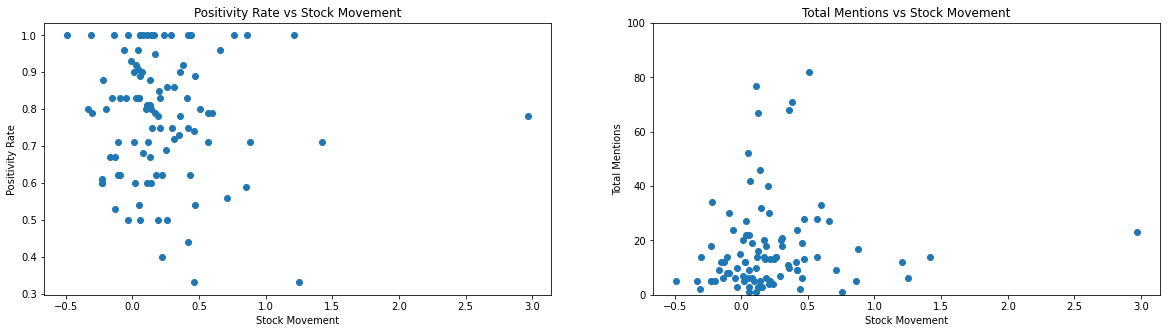

In [58]:
print('correlation: ', np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

In [59]:
industry = 'Industrials'
subindustry = 'Machinery'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country) & df_comp['filtered_names_match'].isin(comp_select)]
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['topic_score'] > 0.5]
df_top_sent_comp = df_top_sent_comp.explode('topic_label').groupby(['filtered_names_match', 'topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
#df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
df_top_sent_comp[df_top_sent_comp['Total'] >= 10][:30]

NEGATIVE  POSITIVE  Total
filtered_names_match topic_label                                     
AAP, Inc.            case_numbers               11.0       4.0   15.0
                     covid                      40.0      13.0   53.0
                     india                      17.0       5.0   22.0
                     other                      12.0       3.0   15.0
                     remote_learning             8.0       2.0   10.0
                     schools                    13.0       4.0   17.0
                     us                          8.0       2.0   10.0
Caterpillar Inc.                                81.0      26.0  107.0
                     finance                   140.0      92.0  232.0
                     general_stock_updates      57.0      36.0   93.0
                     general_updates            12.0      14.0   26.0
                     result_announcements        3.0       8.0   11.0
                     technavio_updates           8.0      12.0   20.0
                     us_shares                  28.0      13.0   41.0
                     us_stock_updates            5.0       6.0   11.0
Deere & Company                                 15.0       4.0   19.0
                     covid                      24.0       5.0   29.0
                     finance                    28.0      29.0   57.0
                     general_stock_updates       3.0      11.0   14.0
                     us                         14.0       2.0   16.0
SPX Corporation                                139.0      74.0  213.0
                     ad_revenue                  7.0       9.0   16.0
                     airlines                   25.0       4.0   29.0
                     amd                        16.0      20.0   36.0
                     asian_shares               27.0      18.0   45.0
                     bankruptcy                 11.0       1.0   12.0
                     bonds                      18.0       3.0   21.0
                     cannabis_companies          7.0       4.0   11.0
                     china                       8.0       4.0   12.0
                     clothing_retailers         33.0      22.0   55.0

### Airlines

In [60]:
industry = 'Industrials'
subindustry = 'Airlines'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
#df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"Mesa Air Group, Inc.",3.0,7.0,10.0,0.70,MESA,-0.24
"SkyWest, Inc.",11.0,21.0,32.0,0.66,SKYW,-0.29
"Alaska Air Group, Inc.",68.0,102.0,170.0,0.60,ALK,-0.24
Allegiant Travel Company,26.0,36.0,62.0,0.58,ALGT,0.09
"Hawaiian Holdings, Inc.",19.0,23.0,42.0,0.55,HA,-0.30
"Spirit Airlines, Inc.",69.0,67.0,136.0,0.49,SAVE,-0.37
JetBlue Airways Corporation,206.0,179.0,385.0,0.46,JBLU,-0.28
American Airlines Group Inc.,1412.0,1134.0,2546.0,0.45,AAL,-0.36
Southwest Airlines Co.,620.0,461.0,1081.0,0.43,LUV,-0.20


0.3788799284761859


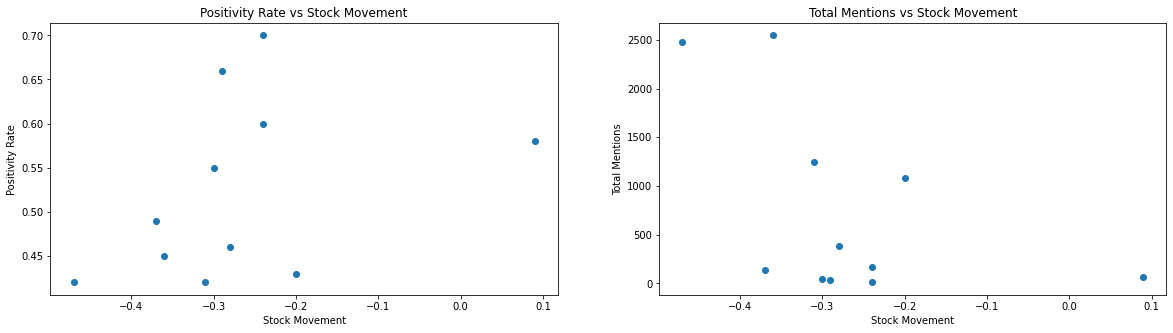

In [61]:
print(np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

In [62]:
industry = 'Industrials'
subindustry = 'Airlines'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country) & df_comp['filtered_names_match'].isin(comp_select)]
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['topic_score'] > 0.5]
df_top_sent_comp = df_top_sent_comp.explode('topic_label').groupby(['filtered_names_match', 'topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
#df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
df_top_sent_comp[df_top_sent_comp['Total'] >= 10][:30]

NEGATIVE  POSITIVE   Total
filtered_names_match         topic_label                                      
American Airlines Group Inc.                           208.0     114.0   322.0
                             airlines                  657.0     178.0   835.0
                             boeing                     65.0      30.0    95.0
                             case_numbers               16.0       5.0    21.0
                             cashay_updates              6.0       8.0    14.0
                             china                       9.0       2.0    11.0
                             company_specific           13.0       4.0    17.0
                             cost_cutting               64.0       9.0    73.0
                             covid                     214.0      50.0   264.0
                             covid_stimulus             11.0       2.0    13.0
                             finance                  1045.0     402.0  1447.0
                             flight_cuts                64.0       9.0    73.0
                             flights_suspended          52.0       6.0    58.0
                             ge_aviationboeing          10.0       3.0    13.0
                             general_stock_updates     109.0     104.0   213.0
                             general_updates             6.0       6.0    12.0
                             hotels                      5.0       6.0    11.0
                             nytimes_updates            35.0       2.0    37.0
                             other                      43.0       5.0    48.0
                             redundancies               26.0       5.0    31.0
                             robinhood_app               8.0       6.0    14.0
                             safety_measures            88.0      12.0   100.0
                             unemployment               31.0       5.0    36.0
                             us                         56.0      11.0    67.0
                             us_shares                  53.0      35.0    88.0
                             us_stock_updates           40.0      25.0    65.0
                             us_stocks_down             15.0       NaN    15.0
                             warren_buffett             31.0       7.0    38.0
Delta Air Lines, Inc.                                  110.0      60.0   170.0
                             airlines                  401.0      84.0   485.0

### Consumer Staples - Food Products

In [63]:
industry = 'Consumer Staples'
subindustry = 'Food Products'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
#df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
The Simply Good Foods Company,0.0,10.0,10.0,1.00,SMPL,0.24
Ingredion Incorporated,1.0,25.0,26.0,0.96,INGR,-0.11
Landec Corporation,1.0,10.0,11.0,0.91,LNDC,-0.05
Lancaster Colony Corporation,1.0,9.0,10.0,0.90,LANC,0.15
"Flowers Foods, Inc.",2.0,16.0,18.0,0.89,FLO,0.10
"B&G Foods, Inc.",5.0,39.0,44.0,0.89,BGS,1.57
"TreeHouse Foods, Inc.",2.0,15.0,17.0,0.88,THS,-0.05
"Conagra Brands, Inc.",6.0,31.0,37.0,0.84,CAG,0.08
Hormel Foods Corporation,9.0,45.0,54.0,0.83,HRL,0.01


0.1758729371861399


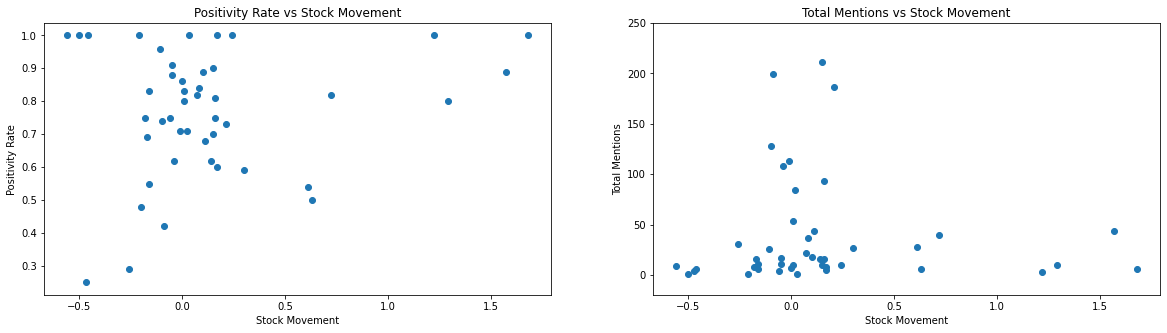

In [64]:
print(np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
ax2.set_ylim(top=250)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

### Consumer Staples - Food Products - Australia

In [65]:
industry = 'Consumer Staples'
#subindustry = 'Food Products'
country = 'Australia'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['country'] == country)]
#df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_au_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp#[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Woolworths Group Limited,8.0,11.0,19.0,0.58,WOW,0.00
Elders Limited,3.0,11.0,14.0,0.79,ELD,0.46
Coles Group Limited,6.0,7.0,13.0,0.54,COL,0.14
Costa Group Holdings Limited,5.0,4.0,9.0,0.44,CGC,0.45
Inghams Group Limited,0.0,2.0,2.0,1.00,ING,-0.03
Australian Agricultural Company Limited,2.0,0.0,2.0,0.00,AAC,-0.01
Freedom Foods Group Limited,1.0,1.0,2.0,0.50,FNP,-0.37
GrainCorp Limited,0.0,1.0,1.0,1.00,GNC,-0.51
Clean Seas Seafood Limited,0.0,1.0,1.0,1.00,CSS,0.13


-0.08519871972847436


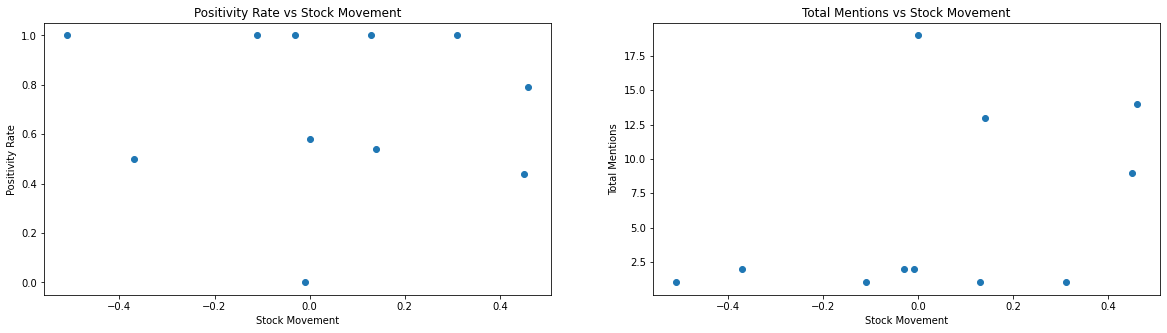

In [66]:
print(np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
#ax2.set_ylim(top=250)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

# By Company

In [67]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,nb_comp_0,industry,subindustry,ticker_symbol,country,company_relevance
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0,Industrials,Machinery,CAT,United States,0.2


In [68]:
df_comp_month = df_comp.copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

In [69]:
company_analysis = 'NVIDIA Corporation'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
#df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
df_comp_analysis

roberta,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,0,1,1,1.00,0.142283
1,2,33,37,70,0.53,-0.023373
2,3,10,17,27,0.63,0.108801
3,4,7,16,23,0.70,0.214657
4,5,13,50,63,0.79,0.070109
5,6,7,74,81,0.91,0.118117
6,7,11,60,71,0.85,0.259992
7,8,13,45,58,0.78,0.011664
8,9,15,96,111,0.86,-0.073371
9,10,4,10,14,0.71,0.069212


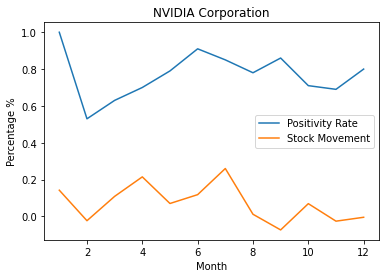

In [70]:
plt.plot('month', 'POS_%', data=df_comp_analysis, label='Positivity Rate')
plt.plot('month', 'stock_mvmt', data=df_comp_analysis, label='Stock Movement')
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

In [71]:
company_analysis = 'American Airlines Group Inc.'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
#df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count')
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
df_comp_analysis

roberta,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,71,21,92,0.23,-0.290239
1,2,87,17,104,0.16,-0.357740
2,3,222,87,309,0.28,-0.014766
3,4,104,85,189,0.45,-0.125729
4,5,128,115,243,0.47,0.244762
5,6,220,285,505,0.56,-0.149197
6,7,297,180,477,0.38,0.173561
7,8,57,58,115,0.50,-0.058238
8,9,84,88,172,0.51,-0.082181
9,10,54,47,101,0.47,0.252660


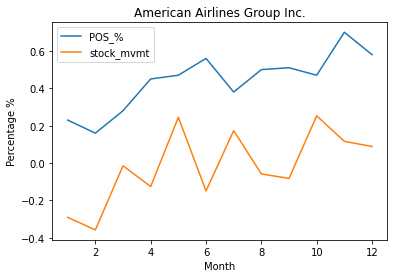

In [72]:
plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

# By Company - Company Relevance

In [73]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,nb_comp_0,industry,subindustry,ticker_symbol,country,company_relevance
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0,Industrials,Machinery,CAT,United States,0.2


roberta,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,2,25,26,51,0.51,-0.023373
1,3,4,16,20,0.80,0.108801
2,4,5,8,13,0.62,0.214657
3,5,7,41,48,0.85,0.070109
4,6,2,39,41,0.95,0.118117
5,7,3,35,38,0.92,0.259992
6,8,10,27,37,0.73,0.011664
7,9,11,63,74,0.85,-0.073371
8,10,2,5,7,0.71,0.069212
9,11,4,6,10,0.60,-0.025855


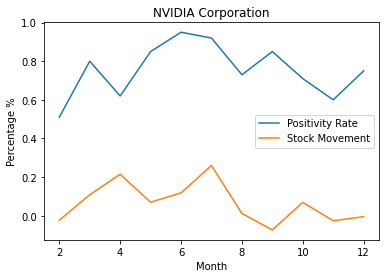

In [74]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

company_analysis = 'NVIDIA Corporation'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
#df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
display(df_comp_analysis)

plt.plot('month', 'POS_%', data=df_comp_analysis, label='Positivity Rate')
plt.plot('month', 'stock_mvmt', data=df_comp_analysis, label='Stock Movement')
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

roberta,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,42,14,56,0.25,-0.290239
1,2,47,8,55,0.15,-0.357740
2,3,139,49,188,0.26,-0.014766
3,4,55,36,91,0.40,-0.125729
4,5,70,62,132,0.47,0.244762
5,6,125,153,278,0.55,-0.149197
6,7,196,97,293,0.33,0.173561
7,8,47,40,87,0.46,-0.058238
8,9,73,64,137,0.47,-0.082181
9,10,38,31,69,0.45,0.252660


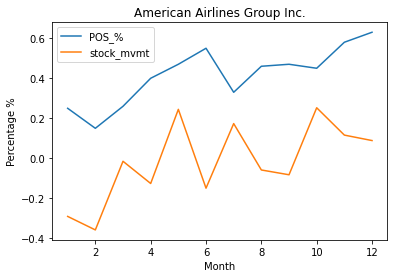

In [75]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

company_analysis = 'American Airlines Group Inc.'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
#df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count')
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
display(df_comp_analysis)

plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

roberta,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,0,1,1,1.00,-0.052810
1,2,3,3,6,0.50,-0.022847
2,3,8,8,16,0.50,0.096007
3,4,13,14,27,0.52,0.019925
4,5,9,16,25,0.64,0.027897
5,6,24,39,63,0.62,0.003257
6,7,8,71,79,0.90,0.036283
7,8,7,52,59,0.88,0.043342
8,9,33,83,116,0.72,-0.060134
9,10,2,2,4,0.50,0.032859


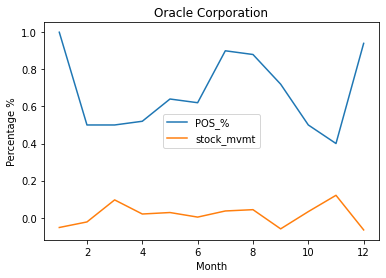

In [76]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

company_analysis = 'Oracle Corporation'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
#df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
display(df_comp_analysis)

plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

# Industries

In [264]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

exclude_marketscreener = False

if exclude_marketscreener:
    df_comp_analysis = df_comp_month[df_comp_month['domain'] != "marketscreener"].copy()
else:
    df_comp_analysis = df_comp_month.copy()
#df_comp_analysis = df_comp_analysis.pivot_table(index=['industry', 'month'], columns='sentiment', values='date', aggfunc='count')
df_comp_analysis = df_comp_analysis.pivot_table(index=['industry', 'month'], columns='roberta', values='date', aggfunc='count')
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

stock_log_ind_mvmt = stock_log_ind.T.pct_change()
stock_log_ind_mvmt = stock_log_ind_mvmt.dropna()
stock_log_ind_mvmt.index = [1,2,3,4,5,6,7,8,9,10,11,12]
stock_log_ind_mvmt = pd.DataFrame(stock_log_ind_mvmt.stack()).reset_index()
stock_log_ind_mvmt.columns = ['month', 'industry', 'stock_mvmt']

df_comp_analysis = df_comp_analysis.merge(stock_log_ind_mvmt, left_on=['industry', 'month'], right_on=['industry', 'month'])
display(df_comp_analysis)

# Cum movement
df_comp_analysis_cum = df_comp_analysis[['industry','month','stock_mvmt']].copy()
df_comp_analysis_cum = df_comp_analysis_cum.set_index(['industry', 'month'])
df_comp_analysis_cum = df_comp_analysis_cum.unstack('industry')
df_comp_analysis_cum = (df_comp_analysis_cum + 1).cumprod() - 1
df_comp_analysis_cum.columns = df_comp_analysis_cum.columns.droplevel()

,industry,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,Consumer Discreptionary,1,171,103,274,0.38,-0.009827
1,Consumer Discreptionary,2,716,426,1142,0.37,-0.036201
2,Consumer Discreptionary,3,2646,1692,4338,0.39,-0.142847
3,Consumer Discreptionary,4,2018,2261,4279,0.53,0.079802
4,Consumer Discreptionary,5,2410,3157,5567,0.57,0.034457
...,...,...,...,...,...,...,...
127,Utilities,8,101,267,368,0.73,0.001979
128,Utilities,9,99,175,274,0.64,-0.007072
129,Utilities,10,41,76,117,0.65,0.007342
130,Utilities,11,50,155,205,0.76,0.021823


In [152]:
df_comp_analysis['industry'].unique()

array(['Consumer Discreptionary', 'Consumer Staples', 'Energy',
       'Financials', 'Healthcare', 'Industrials',
       'Information Technology', 'Materials', 'Real Estate',
       'Telecommunication Services', 'Utilities'], dtype=object)

<AxesSubplot:xlabel='month'>

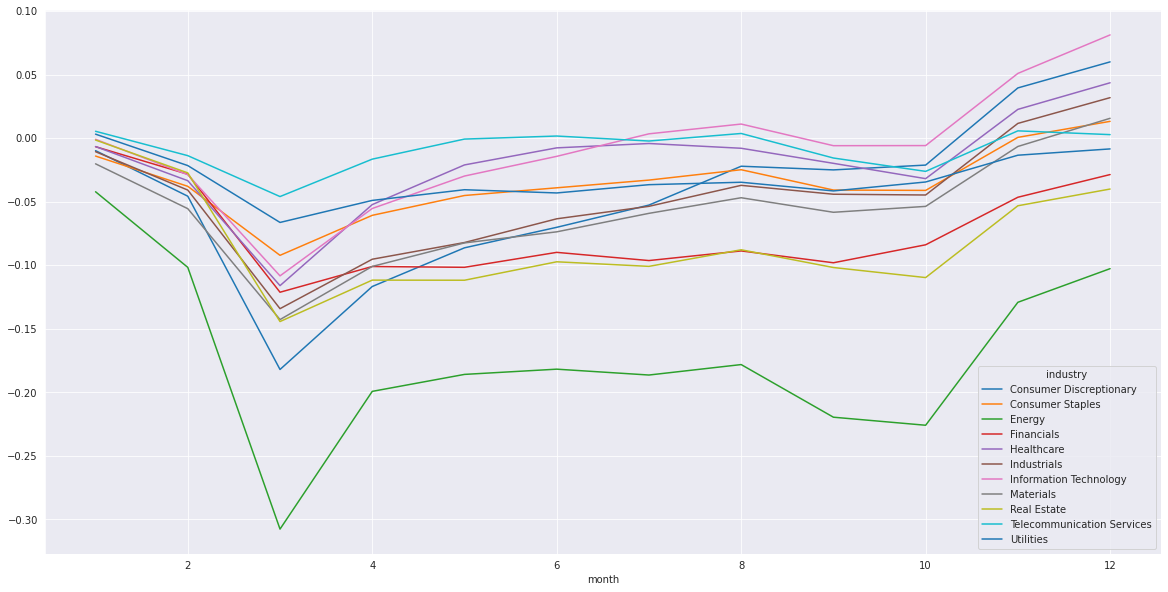

In [266]:
df_comp_analysis_cum.plot(figsize=(20,10))

<ipython-input-243-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-243-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-243-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-243-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-243-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-243-c61474b040cb>:13: UserWarning: FixedFormatter should only be used 

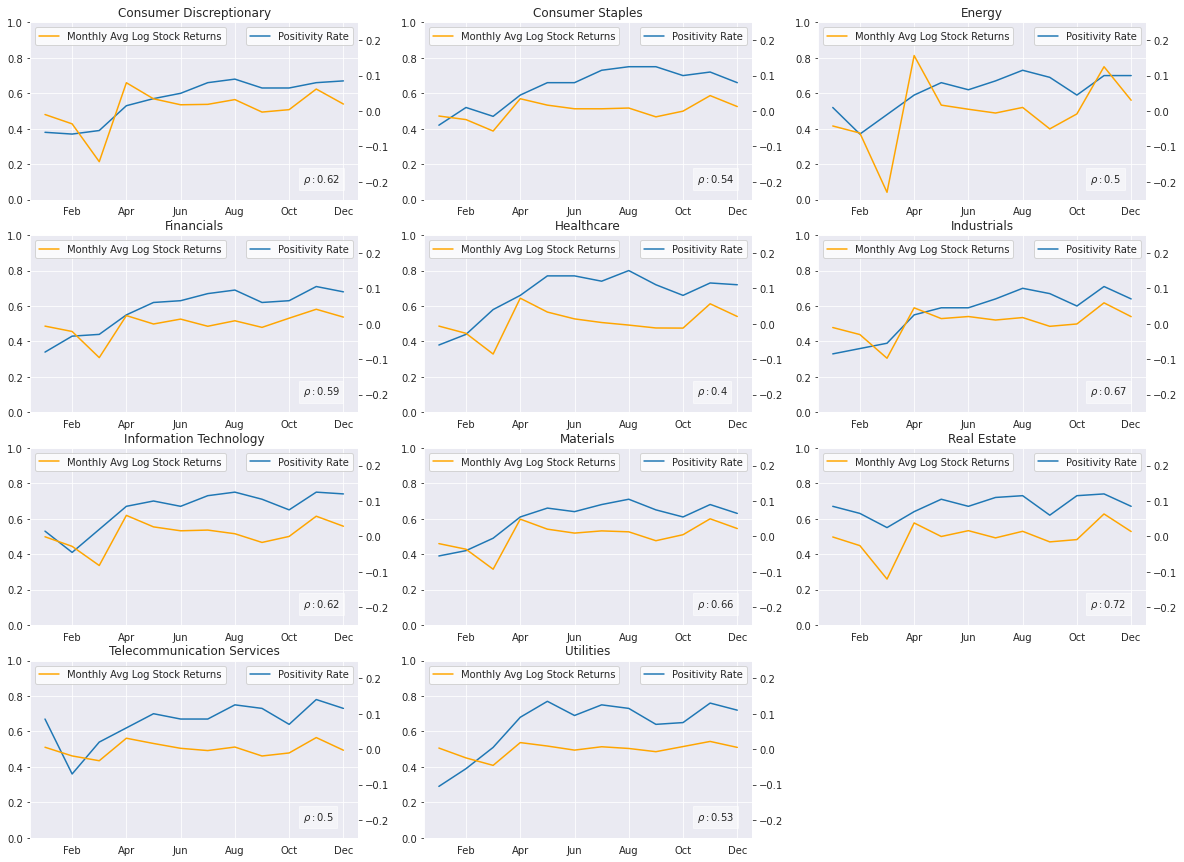

In [243]:
sns.set_style("darkgrid",)
fig, ax = plt.subplots(4,3, figsize=(20,15), sharey=False)
ax = ax.flatten()
ax[11].axis('off')

for idx, industry in enumerate(df_comp_analysis['industry'].unique()):
    ax2 = ax[idx].twinx()
    ax2.plot('month', 'stock_mvmt', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Monthly Avg Log Stock Returns", color="orange")
    ax[idx].plot('month', 'POS_%', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Positivity Rate")
    ax[idx].set_title(industry)
    #ax[idx].set_xlabel('Month - Year 2020')
    #ax[idx].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
    ax[idx].legend(facecolor='white')
    ax[idx].set_ylim(0,1)
    ax2.set_ylim(-0.25,0.25)
    ax2.legend(loc="upper left", facecolor='white')
    ax2.grid(axis='y', visible=False)
    corr = round(np.corrcoef(df_comp_analysis[df_comp_analysis['industry'] == industry]['POS_%'], df_comp_analysis[df_comp_analysis['industry'] == industry]['stock_mvmt']).flatten()[1],2)
    ax[idx].text(10.5, 0.1, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))

# Potential Areas
- Supply chain
- Digitisation
- Product Developments
- Employee Pay


In [83]:
df_topics.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating,topic_words,primary_topic,secondary_topics,topic_label_str
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,970,,0.437342,low,"[caterpillar, ibe, fourthquarter, secondquarte...",,,


# Specific Topic Words Mentioned in an Article

In [84]:
keyword = 'supply_chain'
df_kw = df_combined[df_combined['topic_words'].apply(lambda x: keyword in x)]
df_kw = df_kw.explode('filtered_names_match')
df_kw_financials = df_kw.pivot_table(index='filtered_names_match', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_kw_financials['Total'] = df_kw_financials.sum(axis=1)
df_kw_financials['POS_%'] = round(df_kw_financials['POSITIVE'] / df_kw_financials['Total'],2)

df_kw_financials = df_kw_financials.reset_index()
df_kw_financials['ticker'] = df_kw_financials['filtered_names_match'].map(comp_ticker_dict)
df_kw_financials['stock_mvmt'] = df_kw_financials['ticker'].map(stock_final_mvmt_dict)
df_kw_financials = df_kw_financials[df_kw_financials['stock_mvmt'].notna()]
df_kw_financials = df_kw_financials[df_kw_financials['Total'] > 5]
df_kw_financials[:10]

sentiment,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
0,3D Resources Limited,0,6,6,1.00,DDD,2.26
1,3M Company,7,2,9,0.22,MMM,0.15
18,"Advanced Micro Devices, Inc.",3,3,6,0.50,AMD,0.82
27,American Airlines Group Inc.,7,1,8,0.12,AAL,-0.36
40,Apple Inc.,142,37,179,0.21,AAPL,0.72
58,Ball Corporation,9,21,30,0.70,BLL,0.23
59,Bank of America Corporation,13,1,14,0.07,BAC,-0.07
68,"BlackRock, Inc.",2,4,6,0.67,BLK,0.36
112,Citigroup Inc.,4,2,6,0.33,C,-0.19
161,Ford Motor Company,2,5,7,0.71,F,0.21


0.30325060520471914


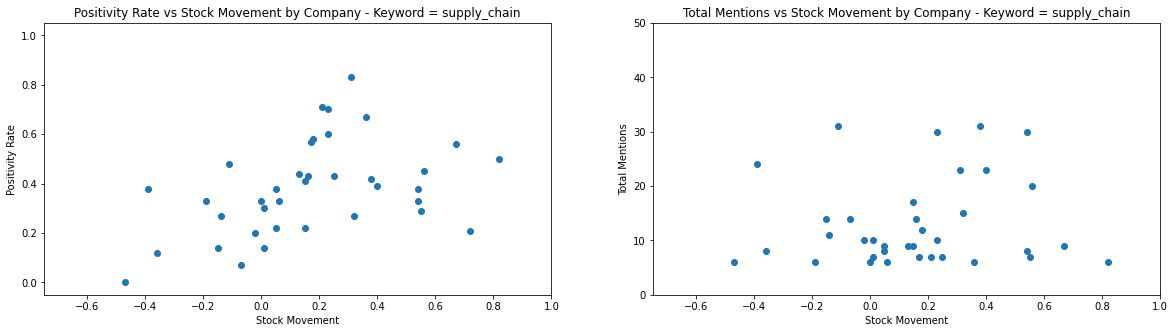

In [85]:
print(np.corrcoef(df_kw_financials['POS_%'], df_kw_financials['stock_mvmt']).flatten()[1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_kw_financials)
ax2.scatter(x="stock_mvmt", y="Total", data=df_kw_financials)
ax2.set_ylim(bottom=0, top=50)
ax1.set_xlim(right=1)
ax2.set_xlim(right=1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(label=("Positivity Rate vs Stock Movement by Company - Keyword = " + keyword))
ax2.set_title(label=("Total Mentions vs Stock Movement by Company - Keyword = " + keyword))
plt.show()

In [86]:
keyword = 'digitization'
df_kw = df_combined[df_combined['topic_words'].apply(lambda x: keyword in x)]
df_kw = df_kw.explode('filtered_names_match')
df_kw_financials = df_kw.pivot_table(index='filtered_names_match', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_kw_financials['Total'] = df_kw_financials.sum(axis=1)
df_kw_financials['POS_%'] = round(df_kw_financials['POSITIVE'] / df_kw_financials['Total'],2)

df_kw_financials = df_kw_financials.reset_index()
df_kw_financials['ticker'] = df_kw_financials['filtered_names_match'].map(comp_ticker_dict)
df_kw_financials['stock_mvmt'] = df_kw_financials['ticker'].map(stock_final_mvmt_dict)
df_kw_financials = df_kw_financials[df_kw_financials['stock_mvmt'].notna()]
df_kw_financials = df_kw_financials[df_kw_financials['Total'] > 5]
df_kw_financials[:10]

sentiment,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
2,3D Resources Limited,16,38,54,0.70,DDD,2.26
11,"ACI Worldwide, Inc.",9,20,29,0.69,ACIW,0.11
13,AECOM,2,12,14,0.86,ACM,0.04
22,AMP Limited,1,11,12,0.92,AMP,0.23
24,"ANI Pharmaceuticals, Inc.",1,5,6,0.83,ANIP,-0.54
35,AT&T Inc.,6,8,14,0.57,T,-0.19
46,Adobe Inc.,7,18,25,0.72,ADBE,0.31
72,"Amazon.com, Inc.",3,10,13,0.77,AMZN,0.60
73,Amdocs Limited,3,4,7,0.57,DOX,0.00
74,American Airlines Group Inc.,4,3,7,0.43,AAL,-0.36


0.053395633776234866


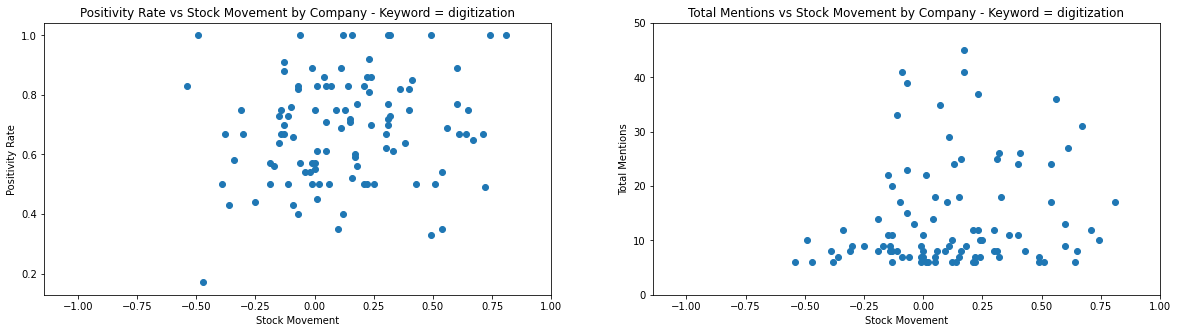

In [87]:
print(np.corrcoef(df_kw_financials['POS_%'], df_kw_financials['stock_mvmt']).flatten()[1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_kw_financials)
ax2.scatter(x="stock_mvmt", y="Total", data=df_kw_financials)
ax2.set_ylim(bottom=0, top=50)
ax1.set_xlim(right=1)
ax2.set_xlim(right=1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(label=("Positivity Rate vs Stock Movement by Company - Keyword = " + keyword))
ax2.set_title(label=("Total Mentions vs Stock Movement by Company - Keyword = " + keyword))
plt.show()

# Domain

In [88]:
df_combined['domain'].value_counts()

finance.yahoo      91304
marketscreener     77255
express            44938
reuters            23856
cnbc               20962
                   ...  
instyle               34
altassets             22
emerj                 20
just-auto              9
businessinsider        3
Name: domain, Length: 66, dtype: int64

<AxesSubplot:xlabel='domain'>

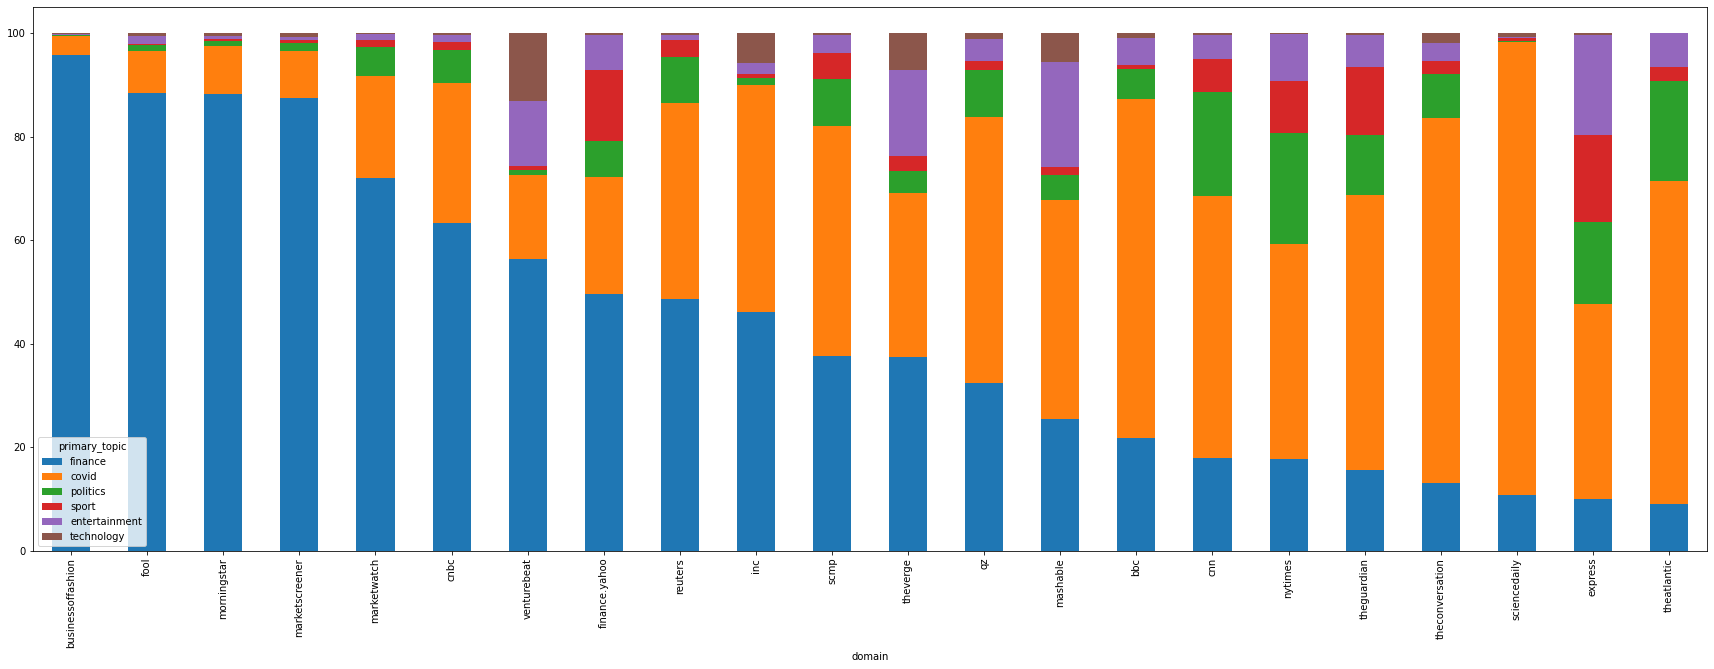

In [89]:
df_domain_chart = df_combined.pivot_table(index=['domain'], columns=['primary_topic'], values='date', aggfunc='count', fill_value=0)
num_articles_mask = df_domain_chart.sum(axis=1) > 1000
df_domain_chart = df_domain_chart[num_articles_mask]
df_domain_chart = df_domain_chart[['finance', 'covid', 'politics', 'sport', 'entertainment', 'technology']]
df_domain_chart = df_domain_chart.div(df_domain_chart.sum(axis=1), axis=0).multiply(100)
df_domain_chart = df_domain_chart.sort_values(by="finance", ascending=False)
df_domain_chart
df_domain_chart.plot.bar(stacked=True, figsize = (30,10))

<AxesSubplot:xlabel='domain'>

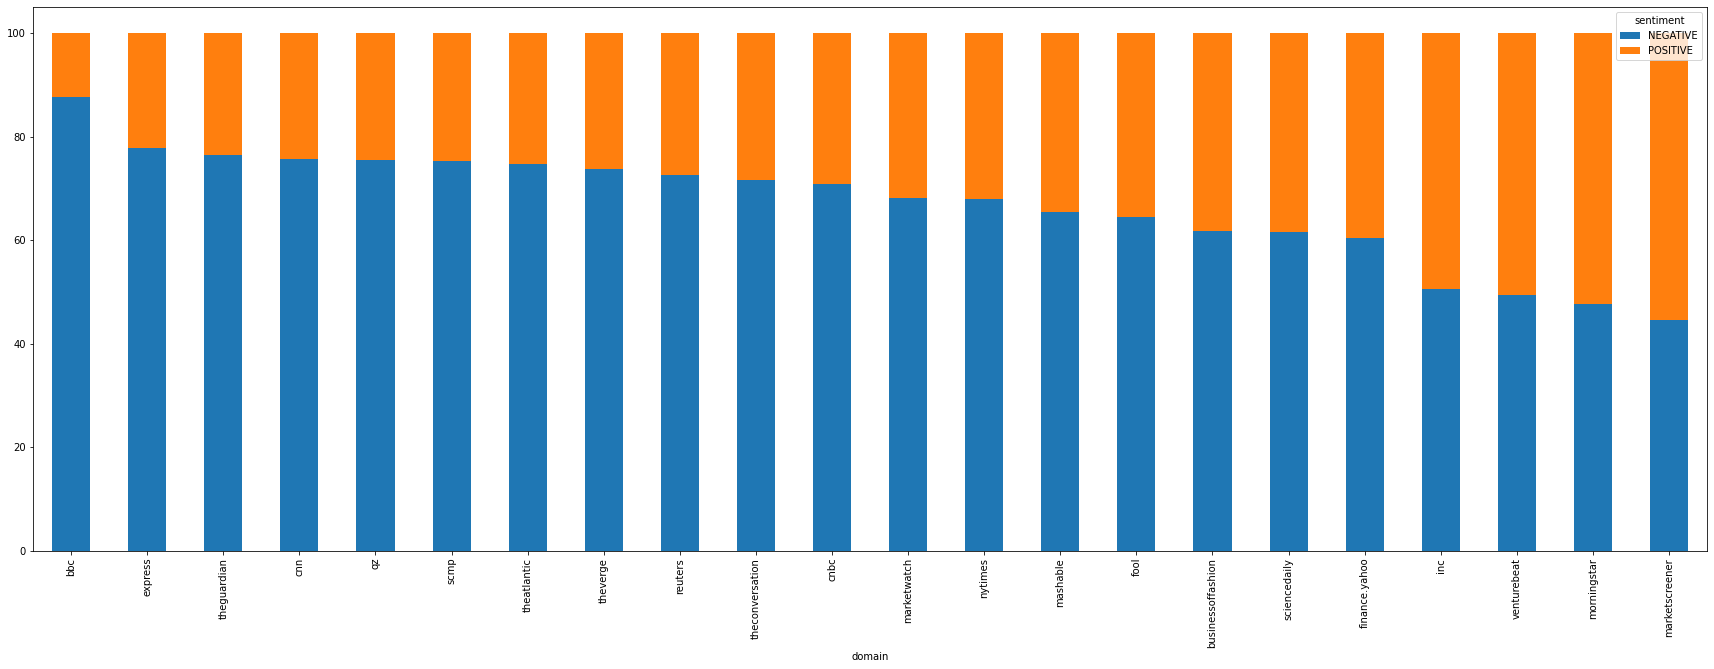

In [90]:
df_domain_chart = df_combined[df_combined['primary_topic'] == 'finance']
df_domain_chart = df_combined.pivot_table(index=['domain'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
num_articles_mask = df_domain_chart.sum(axis=1) > 1000
df_domain_chart = df_domain_chart[num_articles_mask]
df_domain_chart = df_domain_chart.div(df_domain_chart.sum(axis=1), axis=0).multiply(100)
df_domain_chart = df_domain_chart.sort_values(by="NEGATIVE", ascending=False)
df_domain_chart.plot.bar(stacked=True, figsize = (30,10))

# Countries

### Sentiment

/home/ubuntu/thesis_env2/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ubuntu/thesis_env2/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


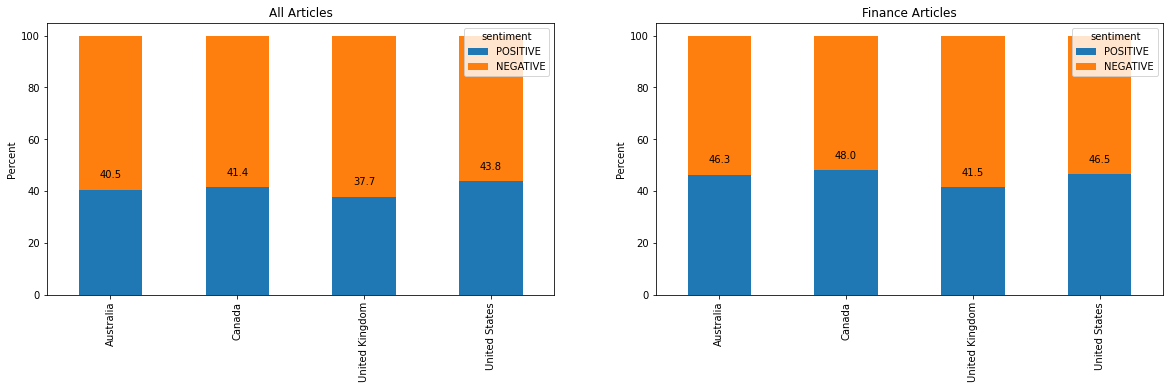

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

# All topics
df_comp_chart = df_comp.pivot_table(index="country", columns="sentiment", values="date", aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart[['POSITIVE', 'NEGATIVE']]
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="country", ascending=True)
df_comp_chart.plot.bar(stacked=True, title="All Articles", xlabel="", ylabel="Percent", ax=ax1)
for c in ax1.containers[::2]:
    ax1.bar_label(c, label_type='edge', fmt='%0.1f', padding=10)
None

# Finance
df_comp_chart = df_comp[df_comp['primary_topic'] == 'finance']
df_comp_chart = df_comp_chart.pivot_table(index="country", columns="sentiment", values="date", aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart[['POSITIVE', 'NEGATIVE']]
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="country", ascending=True)
df_comp_chart.plot.bar(stacked=True, title="Finance Articles", xlabel="", ylabel="Percent", ax=ax2)
for c in ax2.containers[::2]:
    ax2.bar_label(c, label_type='edge', fmt='%0.1f', padding=10)
None

In [47]:
df_comp_chart

sentiment,NEGATIVE,POSITIVE
country,,
Australia,53.665062,46.334938
Canada,51.999703,48.000297
United Kingdom,58.480705,41.519295
United States,53.503100,46.496900


### Topics

<AxesSubplot:xlabel='country'>

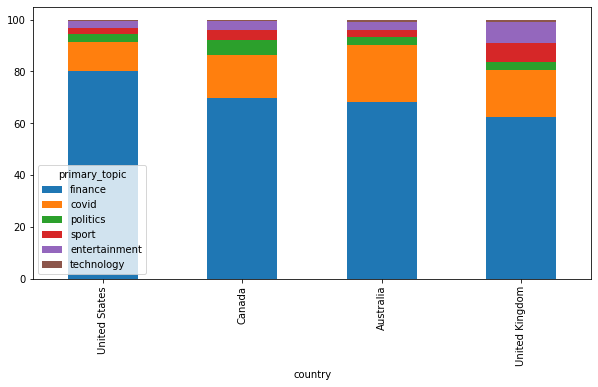

In [93]:
df_comp_chart = df_comp.pivot_table(index=['country'], columns=['primary_topic'], values='date', aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart[['finance', 'covid', 'politics', 'sport', 'entertainment', 'technology']]
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="finance", ascending=False)
df_comp_chart
df_comp_chart.plot.bar(stacked=True, figsize = (10,5))

### Monthly

In [83]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word,month,industry,subindustry,ticker_symbol,country,company_relevance
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0.692542,0.646232,0.677501,0.625921,1,Industrials,Machinery,CAT,United States,0.2


In [111]:
df_sent_month_comp = df_comp.pivot_table(index=['country','month'], columns='roberta', values='date', aggfunc='count', fill_value=0)
df_sent_month_comp

df_sent_month_comp['Total'] = df_sent_month_comp.sum(axis=1)
df_sent_month_comp['POS_%'] = round(df_sent_month_comp['POSITIVE'] / df_sent_month_comp['Total'],2)
df_sent_month_comp = df_sent_month_comp['POS_%'].unstack(level='country')

stock_mvmt_analysis = stock_indices.T.pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_sent_month_comp = pd.concat([df_sent_month_comp, stock_mvmt_analysis], axis=1)
df_sent_month_comp = df_sent_month_comp.reset_index()
df_sent_month_comp = df_sent_month_comp.rename(columns={'index': 'month'})
display(df_sent_month_comp)

# Cum movement
df_sent_month_comp_cum = df_sent_month_comp.copy()
df_sent_month_comp_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] = (df_sent_month_comp_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] + 1).cumprod() - 1

,month,Australia,Canada,United Kingdom,United States,S&P500,Dow30,Nasdaq,FTSE100,ASX200,TSX
0,1,0.19,0.33,0.34,0.45,-0.001628,-0.009896,0.019876,-0.033994,0.049835,0.014950
1,2,0.42,0.41,0.35,0.42,-0.084110,-0.100746,-0.063772,-0.096816,-0.082084,-0.060941
2,3,0.48,0.47,0.40,0.46,-0.125119,-0.137438,-0.101229,-0.138073,-0.211824,-0.177352
3,4,0.59,0.56,0.52,0.60,0.126844,0.110806,0.154472,0.040409,0.087772,0.104785
4,5,0.67,0.63,0.56,0.66,0.045282,0.042611,0.067531,0.029723,0.042246,0.027881
5,6,0.61,0.62,0.58,0.65,0.018388,0.016931,0.059948,0.015321,0.024706,0.021221
6,7,0.69,0.66,0.64,0.70,0.055101,0.023842,0.068249,-0.044070,0.005070,0.042152
7,8,0.68,0.70,0.64,0.75,0.070065,0.075742,0.095874,0.011157,0.022386,0.021349
8,9,0.65,0.63,0.59,0.69,-0.039228,-0.022805,-0.051629,-0.016349,-0.040360,-0.023797
9,10,0.68,0.57,0.52,0.64,-0.027666,-0.046077,-0.022916,-0.049232,0.019206,-0.033546


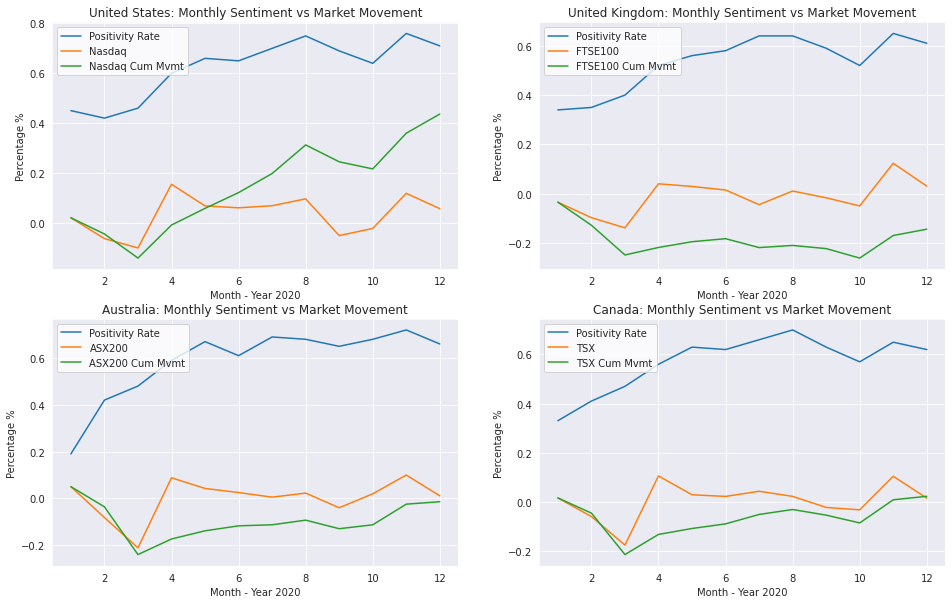

In [145]:
sns.set_style(style='darkgrid')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,10))
countries_index = [(ax1, 'United States', 'Nasdaq'),(ax2, 'United Kingdom', 'FTSE100'),(ax3, 'Australia', 'ASX200'),(ax4, 'Canada', 'TSX')]

for ax, country, index in countries_index:
    ax.plot('month', country, data=df_sent_month_comp, label='Positivity Rate')
    ax.plot('month', index, data=df_sent_month_comp, label=index)
    ax.plot('month', index, data=df_sent_month_comp_cum, label=f'{index} Cum Mvmt')
    ax.set_xlabel("Month - Year 2020")
    ax.set_ylabel("Percentage %")
    ax.legend(loc='upper left', facecolor='white')
    ax.set_title(f'{country}: Monthly Sentiment vs Market Movement')

In [208]:
df_sent_month_comp

,month,Australia,Canada,United Kingdom,United States,S&P500,Dow30,Nasdaq,FTSE100,ASX200,TSX
0,1,0.19,0.33,0.34,0.45,-0.001628,-0.009896,0.019876,-0.033994,0.049835,0.014950
1,2,0.42,0.41,0.35,0.42,-0.084110,-0.100746,-0.063772,-0.096816,-0.082084,-0.060941
2,3,0.48,0.47,0.40,0.46,-0.125119,-0.137438,-0.101229,-0.138073,-0.211824,-0.177352
3,4,0.59,0.56,0.52,0.60,0.126844,0.110806,0.154472,0.040409,0.087772,0.104785
4,5,0.67,0.63,0.56,0.66,0.045282,0.042611,0.067531,0.029723,0.042246,0.027881
5,6,0.61,0.62,0.58,0.65,0.018388,0.016931,0.059948,0.015321,0.024706,0.021221
6,7,0.69,0.66,0.64,0.70,0.055101,0.023842,0.068249,-0.044070,0.005070,0.042152
7,8,0.68,0.70,0.64,0.75,0.070065,0.075742,0.095874,0.011157,0.022386,0.021349
8,9,0.65,0.63,0.59,0.69,-0.039228,-0.022805,-0.051629,-0.016349,-0.040360,-0.023797
9,10,0.68,0.57,0.52,0.64,-0.027666,-0.046077,-0.022916,-0.049232,0.019206,-0.033546


In [209]:
print(np.corrcoef(df_sent_month_comp['Australia'], df_sent_month_comp['ASX200']).flatten()[1])
print(np.corrcoef(df_sent_month_comp['Canada'], df_sent_month_comp['TSX']).flatten()[1])
print(np.corrcoef(df_sent_month_comp['United Kingdom'], df_sent_month_comp['FTSE100']).flatten()[1])
print(np.corrcoef(df_sent_month_comp['United States'], df_sent_month_comp['Nasdaq']).flatten()[1])


0.2610114581506542
0.4298816528228194
0.6709246489497799
0.5970562034429587


# Topics - Manual Defined

### Average Document

In [94]:
df_topics_manual.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0.692542,0.646232,0.677501,0.625921


In [95]:
df_topics_manual.columns

Index(['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain',
       'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure',
       'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain',
       'shutdown', 'outsourcing', 'workfromhome', 'diversification',
       'blockchain_word', 'digitization_word', 'machine_learne_word',
       'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word',
       'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
       'shutdown_word', 'outsourcing_word', 'workfromhome_word',
       'diversification_word', 'vaccines_word', 'drug_discovery_word',
       'tele_health_word', 'cybersecurity_word'],
      dtype='object')

In [96]:
df_combined.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,nb_comp_0
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,"[Caterpillar Inc., Cummins Inc., Deere & Compa...",[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0


sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,7,39,46,0.85,MSFT,0.38
"Nasdaq, Inc.",7,25,32,0.78,NDAQ,0.18
"Healthcare Services Group, Inc.",6,18,24,0.75,HCSG,0.31
"Information Services Group, Inc.",8,13,21,0.62,III,0.31
Oracle Corporation,1,16,17,0.94,ORCL,0.17
"Cisco Systems, Inc.",1,12,13,0.92,CSCO,0.00
"VMware, Inc.",1,10,11,0.91,VMW,-0.07
Hewlett Packard Enterprise Company,2,9,11,0.82,HPE,-0.07
"SMART Global Holdings, Inc.",3,8,11,0.73,SGH,0.23


correlation:  -0.5387120901868132


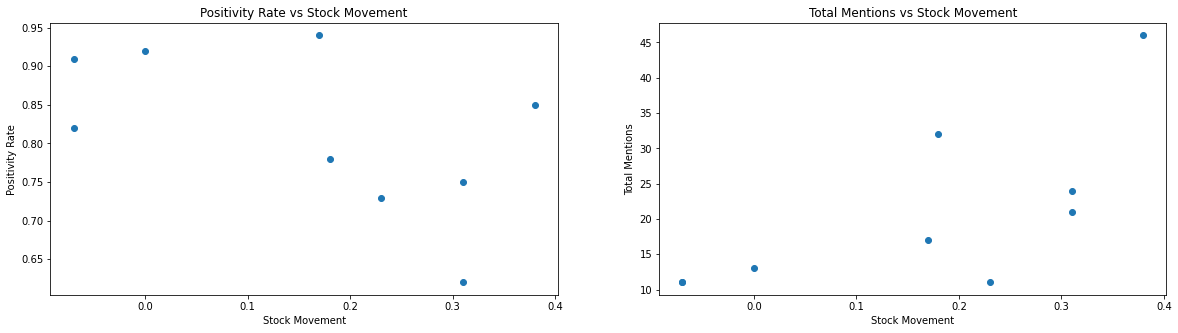

In [97]:
topic = 'digitization'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,10,53,63,0.84,MSFT,0.38
"Nasdaq, Inc.",9,28,37,0.76,NDAQ,0.18
Oracle Corporation,7,28,35,0.80,ORCL,0.17
"Healthcare Services Group, Inc.",8,25,33,0.76,HCSG,0.31
International Business Machines Corporation,5,15,20,0.75,IBM,-0.13
Honeywell International Inc.,4,13,17,0.76,HON,0.15
Intel Corporation,4,13,17,0.76,INTC,-0.11
"SMART Global Holdings, Inc.",3,13,16,0.81,SGH,0.23
Hewlett Packard Enterprise Company,3,12,15,0.80,HPE,-0.07


correlation:  0.28134417768846787


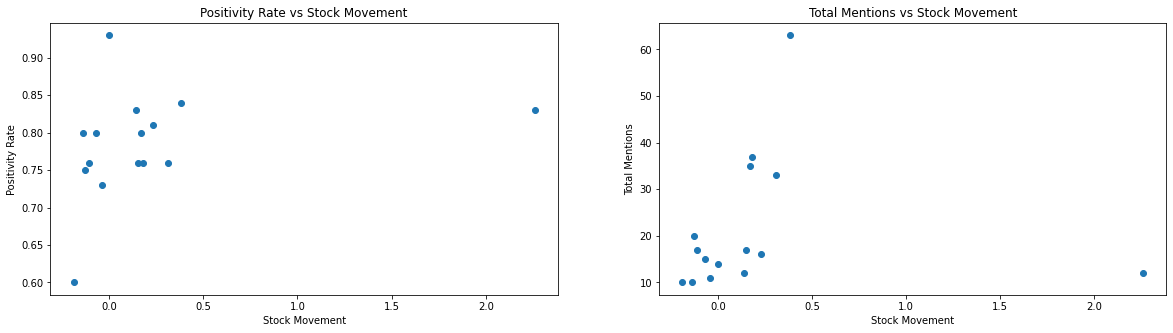

In [98]:
topic = 'iot'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Visa Inc.,18,23,41,0.56,V,-0.02
Apple Inc.,18,19,37,0.51,AAPL,0.72
"PayPal Holdings, Inc.",21,14,35,0.40,PYPL,1.06
"The Goldman Sachs Group, Inc.",17,13,30,0.43,GS,0.17
"Nasdaq, Inc.",14,15,29,0.52,NDAQ,0.18
Mastercard Incorporated,13,12,25,0.48,MA,0.01
JPMorgan Chase & Co.,12,5,17,0.29,JPM,0.01
Microsoft Corporation,11,6,17,0.35,MSFT,0.38
SPX Corporation,8,8,16,0.50,SPXC,0.05


correlation:  0.2100040584260255


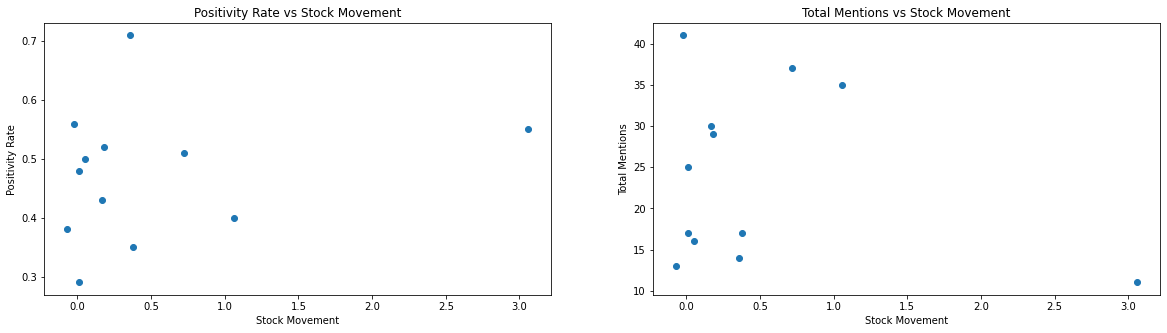

In [99]:
topic = 'blockchain'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Apple Inc.,71,29,100,0.29,AAPL,0.72
Honeywell International Inc.,7,18,25,0.72,HON,0.15
General Motors Company,13,10,23,0.43,GM,0.54
Intel Corporation,13,5,18,0.28,INTC,-0.11
"Tesla, Inc.",5,8,13,0.62,TSLA,5.10
Ford Motor Company,9,4,13,0.31,F,0.21
The Boeing Company,5,6,11,0.55,BA,-0.39


correlation:  0.3435906899604749


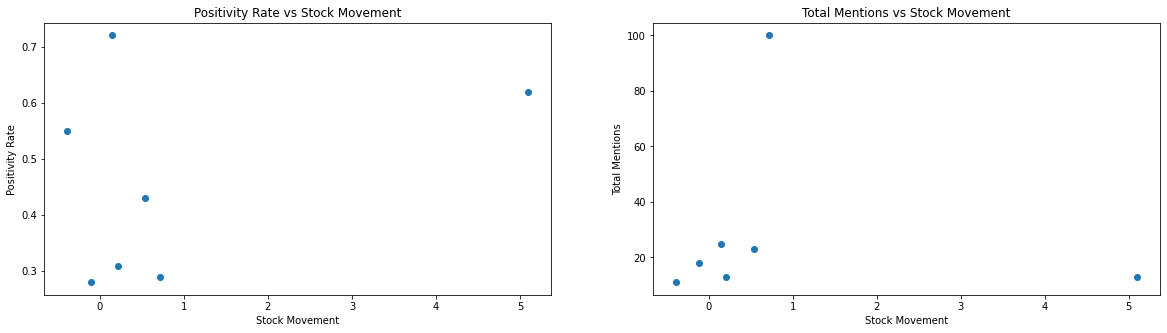

In [100]:
topic = 'supply_chain'
df_top_sent = df_combined.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,43,52,95,0.55,MSFT,0.38
"Nasdaq, Inc.",11,24,35,0.69,NDAQ,0.18
"Zoom Video Communications, Inc.",8,21,29,0.72,ZM,3.88
Apple Inc.,6,18,24,0.75,AAPL,0.72
Vonage Holdings Corp.,3,17,20,0.85,VG,0.41
"VMware, Inc.",7,13,20,0.65,VMW,-0.07
"Healthcare Services Group, Inc.",4,13,17,0.76,HCSG,0.31
Intel Corporation,7,10,17,0.59,INTC,-0.11
"Gartner, Inc.",4,11,15,0.73,IT,-0.06


correlation:  0.12882813548709465


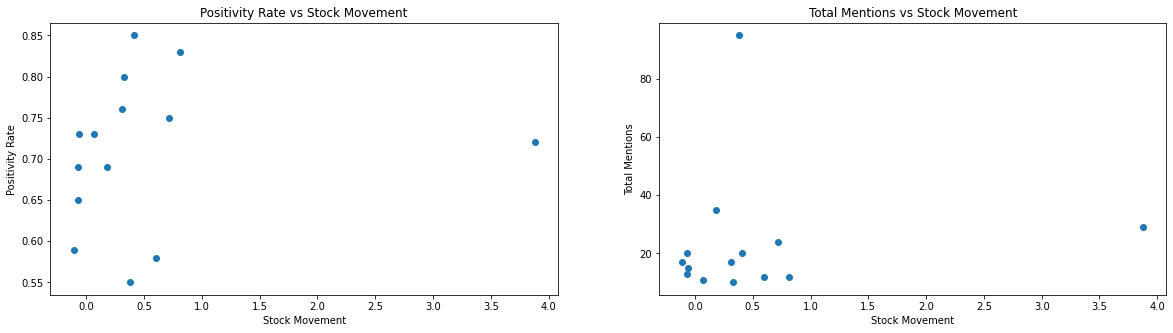

In [101]:
topic = 'workfromhome'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,14,56,70,0.80,MSFT,0.38
Oracle Corporation,9,39,48,0.81,ORCL,0.17
International Business Machines Corporation,11,30,41,0.73,IBM,-0.13
"Healthcare Services Group, Inc.",9,27,36,0.75,HCSG,0.31
Honeywell International Inc.,7,18,25,0.72,HON,0.15
"Nasdaq, Inc.",9,12,21,0.57,NDAQ,0.18
"Cisco Systems, Inc.",2,17,19,0.89,CSCO,0.00
Intel Corporation,3,14,17,0.82,INTC,-0.11
General Electric Company,5,12,17,0.71,GE,-0.14


correlation:  0.37004476532782415


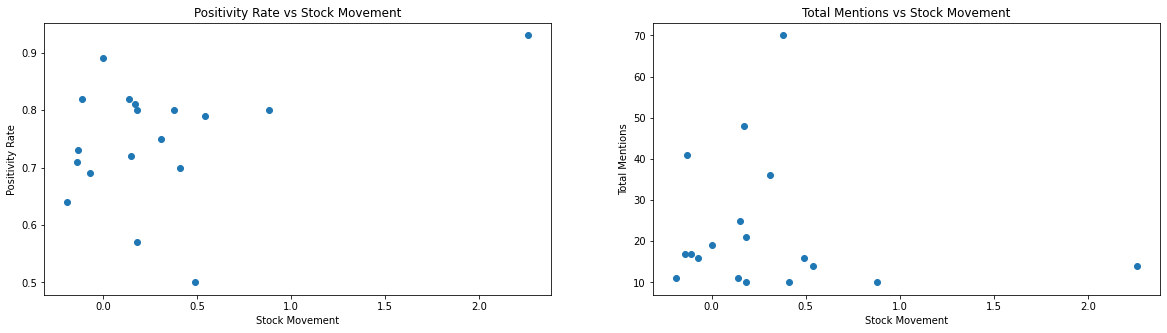

In [102]:
topic = 'outsourcing'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

### Average Word Document

In [103]:
df_topics_manual.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0.692542,0.646232,0.677501,0.625921


In [104]:
df_topics_manual.columns

Index(['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain',
       'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure',
       'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain',
       'shutdown', 'outsourcing', 'workfromhome', 'diversification',
       'blockchain_word', 'digitization_word', 'machine_learne_word',
       'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word',
       'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
       'shutdown_word', 'outsourcing_word', 'workfromhome_word',
       'diversification_word', 'vaccines_word', 'drug_discovery_word',
       'tele_health_word', 'cybersecurity_word'],
      dtype='object')

In [105]:
df_combined.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,nb_comp_0
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,"[Caterpillar Inc., Cummins Inc., Deere & Compa...",[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0


sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"Nasdaq, Inc.",12,41,53,0.77,NDAQ,0.18
Microsoft Corporation,5,40,45,0.89,MSFT,0.38
"Information Services Group, Inc.",10,29,39,0.74,III,0.31
"Healthcare Services Group, Inc.",7,25,32,0.78,HCSG,0.31
"VMware, Inc.",2,13,15,0.87,VMW,-0.07
Hewlett Packard Enterprise Company,3,12,15,0.80,HPE,-0.07
"Gartner, Inc.",3,9,12,0.75,IT,-0.06
3D Resources Limited,1,11,12,0.92,DDD,2.26
"ACI Worldwide, Inc.",1,10,11,0.91,ACIW,0.11


correlation:  0.39258966677802193


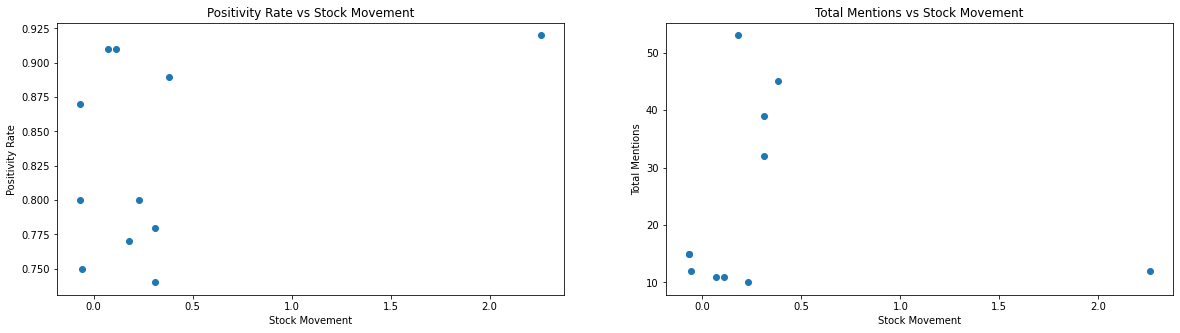

In [106]:
topic = 'digitization_word'
df_top_sent = df_combined.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent['company_relevance'] = df_top_sent.apply(company_relvance_cacl, axis=1)
df_top_sent = df_top_sent[df_top_sent['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"Nasdaq, Inc.",12,29,41,0.71,NDAQ,0.18
Microsoft Corporation,3,36,39,0.92,MSFT,0.38
"Healthcare Services Group, Inc.",2,18,20,0.90,HCSG,0.31
"Information Services Group, Inc.",5,9,14,0.64,III,0.31
Hewlett Packard Enterprise Company,2,11,13,0.85,HPE,-0.07
Service Corporation International,1,11,12,0.92,SCI,0.07
"SMART Global Holdings, Inc.",4,6,10,0.60,SGH,0.23
"Cisco Systems, Inc.",1,9,10,0.90,CSCO,0.00


correlation:  -0.24702186459992947


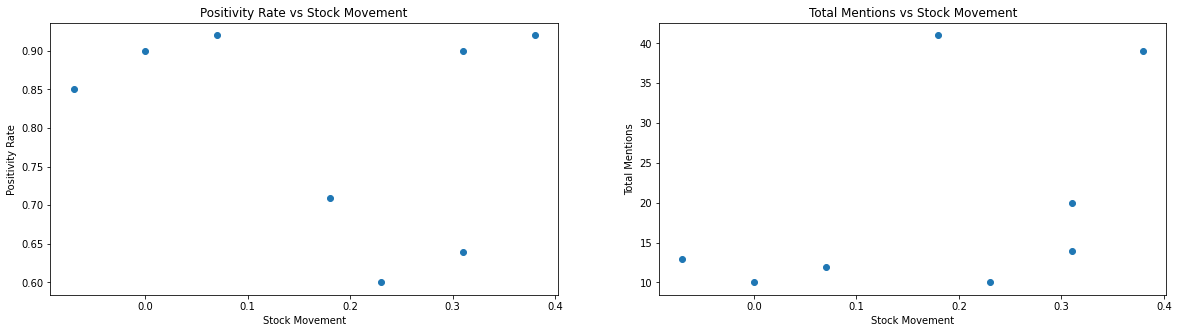

In [107]:
topic = 'iot_word'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"PayPal Holdings, Inc.",24,10,34,0.29,PYPL,1.06
Visa Inc.,13,8,21,0.38,V,-0.02
"The Goldman Sachs Group, Inc.",10,10,20,0.50,GS,0.17
Mastercard Incorporated,10,10,20,0.50,MA,0.01
Apple Inc.,8,9,17,0.53,AAPL,0.72
SPX Corporation,8,8,16,0.50,SPXC,0.05
"Nasdaq, Inc.",6,8,14,0.57,NDAQ,0.18
JPMorgan Chase & Co.,9,3,12,0.25,JPM,0.01
Bank of America Corporation,5,6,11,0.55,BAC,-0.07


correlation:  -0.21753147824694602


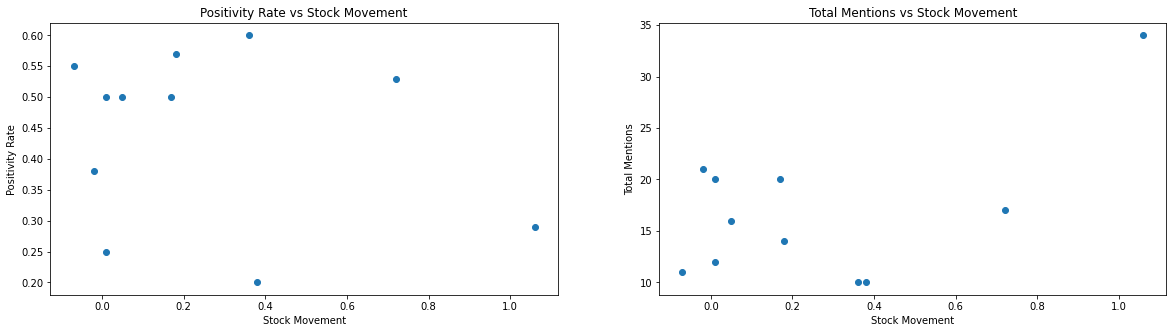

In [108]:
topic = 'blockchain_word'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Apple Inc.,25,2,27,0.07,AAPL,0.72
SPX Corporation,6,9,15,0.60,SPXC,0.05


correlation:  -0.9999999999999999


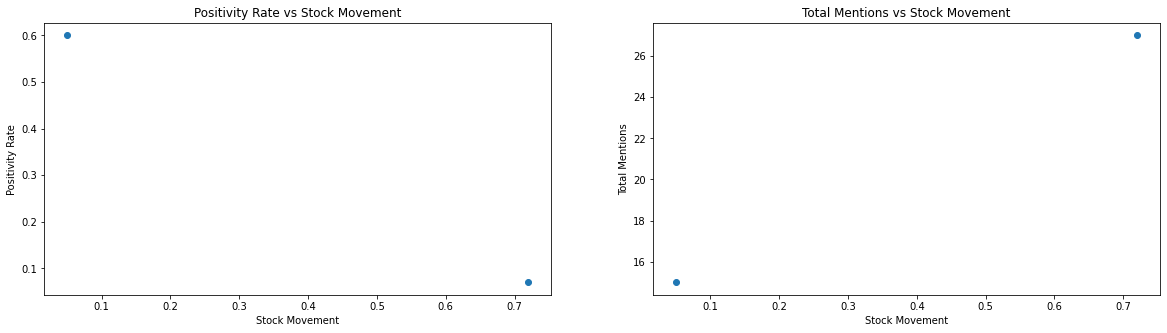

In [109]:
topic = 'supply_chain_word'
df_top_sent = df_combined.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,19,32,51,0.63,MSFT,0.38
"Nasdaq, Inc.",7,19,26,0.73,NDAQ,0.18
Vonage Holdings Corp.,3,8,11,0.73,VG,0.41
"VMware, Inc.",1,9,10,0.90,VMW,-0.07
"RingCentral, Inc.",5,5,10,0.50,RNG,0.81
"Healthcare Services Group, Inc.",2,8,10,0.80,HCSG,0.31


correlation:  -0.9183481572123049


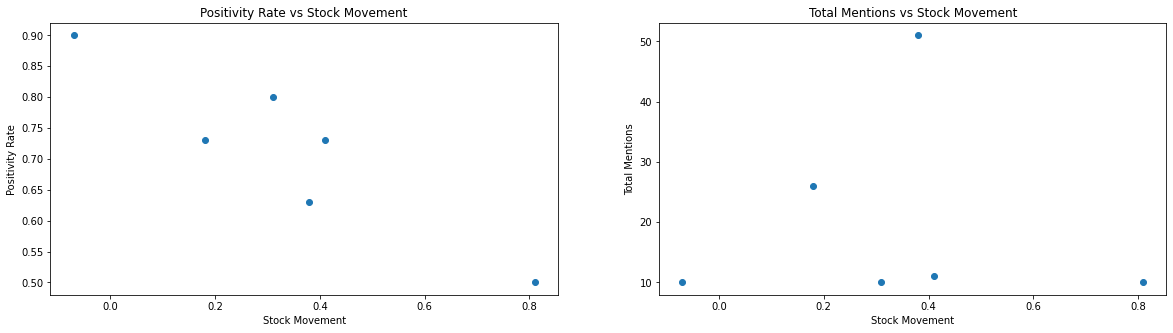

In [110]:
topic = 'workfromhome_word'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"Nasdaq, Inc.",8,24,32,0.75,NDAQ,0.18
Microsoft Corporation,3,26,29,0.90,MSFT,0.38
"Healthcare Services Group, Inc.",5,21,26,0.81,HCSG,0.31
Oracle Corporation,2,15,17,0.88,ORCL,0.17
"Information Services Group, Inc.",3,9,12,0.75,III,0.31
"Cisco Systems, Inc.",0,12,12,1.00,CSCO,0.00
"VMware, Inc.",1,9,10,0.90,VMW,-0.07
Service Corporation International,0,10,10,1.00,SCI,0.07


correlation:  -0.5639083013646571


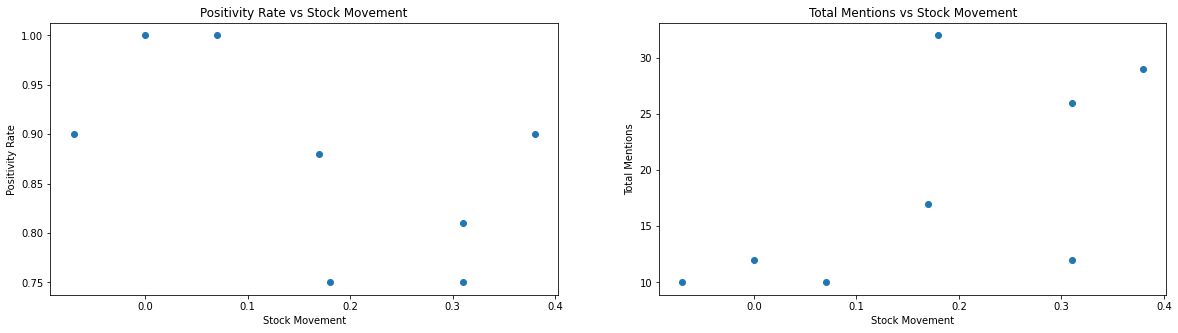

In [111]:
topic = 'outsourcing_word'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

# Sentiment vs Total Market Movement

In [197]:
df_sent_month = df_combined.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_sent_month['Total'] = df_sent_month.sum(axis=1)
df_sent_month['POS_%'] = round(df_sent_month['POSITIVE'] / df_sent_month['Total'],2)

stock_mvmt_analysis = stock_indices.T.pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_sent_month = pd.concat([df_sent_month, stock_mvmt_analysis], axis=1)
df_sent_month = df_sent_month.reset_index()
df_sent_month = df_sent_month.rename(columns={'index': 'month'})
df_sent_month

,month,NEGATIVE,POSITIVE,Total,POS_%,S&P500,Dow30,Nasdaq,FTSE100,ASX200,TSX
0,1,1314,614,1928,0.32,-0.001628,-0.009896,0.019876,-0.033994,0.049835,0.014950
1,2,4982,2900,7882,0.37,-0.084110,-0.100746,-0.063772,-0.096816,-0.082084,-0.060941
2,3,22012,16602,38614,0.43,-0.125119,-0.137438,-0.101229,-0.138073,-0.211824,-0.177352
3,4,21065,22736,43801,0.52,0.126844,0.110806,0.154472,0.040409,0.087772,0.104785
4,5,19118,24795,43913,0.56,0.045282,0.042611,0.067531,0.029723,0.042246,0.027881
5,6,18046,24439,42485,0.58,0.018388,0.016931,0.059948,0.015321,0.024706,0.021221
6,7,29640,41572,71212,0.58,0.055101,0.023842,0.068249,-0.044070,0.005070,0.042152
7,8,14652,21639,36291,0.60,0.070065,0.075742,0.095874,0.011157,0.022386,0.021349
8,9,14872,20818,35690,0.58,-0.039228,-0.022805,-0.051629,-0.016349,-0.040360,-0.023797
9,10,5268,6597,11865,0.56,-0.027666,-0.046077,-0.022916,-0.049232,0.019206,-0.033546


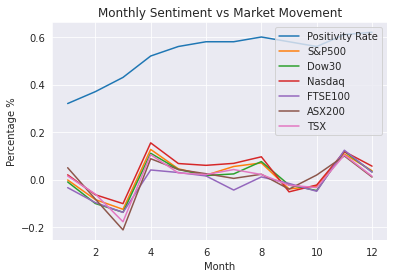

In [198]:
plt.plot('month', 'POS_%', data=df_sent_month, label='Positivity Rate')
plt.plot('month', 'S&P500', data=df_sent_month, label='S&P500')
plt.plot('month', 'Dow30', data=df_sent_month, label='Dow30')
plt.plot('month', 'Nasdaq', data=df_sent_month, label='Nasdaq')
plt.plot('month', 'FTSE100', data=df_sent_month, label='FTSE100')
plt.plot('month', 'ASX200', data=df_sent_month, label='ASX200')
plt.plot('month', 'TSX', data=df_sent_month, label='TSX')

plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title('Monthly Sentiment vs Market Movement')
plt.show()

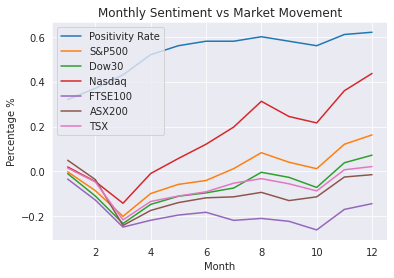

In [199]:
# Cum movement
plt.plot('month', 'POS_%', data=df_sent_month, label='Positivity Rate')
plt.plot('S&P500', data=index_mvmt_analysis_cum, label='S&P500')
plt.plot('Dow30', data=index_mvmt_analysis_cum, label='Dow30')
plt.plot('Nasdaq', data=index_mvmt_analysis_cum, label='Nasdaq')
plt.plot('FTSE100', data=index_mvmt_analysis_cum, label='FTSE100')
plt.plot('ASX200', data=index_mvmt_analysis_cum, label='ASX200')
plt.plot('TSX', data=index_mvmt_analysis_cum, label='TSX')

plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title('Monthly Sentiment vs Market Movement')
plt.show()

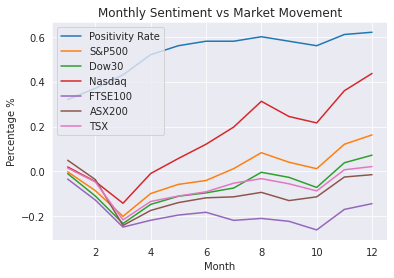

In [200]:
# Cum movement
df_sent_cum = df_sent_month.copy()
df_sent_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] = (df_sent_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] + 1).cumprod() - 1

plt.plot('month', 'POS_%', data=df_sent_cum, label='Positivity Rate')
plt.plot('month', 'S&P500', data=df_sent_cum, label='S&P500')
plt.plot('month', 'Dow30', data=df_sent_cum, label='Dow30')
plt.plot('month', 'Nasdaq', data=df_sent_cum, label='Nasdaq')
plt.plot('month', 'FTSE100', data=df_sent_cum, label='FTSE100')
plt.plot('month', 'ASX200', data=df_sent_cum, label='ASX200')
plt.plot('month', 'TSX', data=df_sent_cum, label='TSX')

plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title('Monthly Sentiment vs Market Movement')
plt.show()

In [201]:
df_sent_cum

,month,NEGATIVE,POSITIVE,Total,POS_%,S&P500,Dow30,Nasdaq,FTSE100,ASX200,TSX
0,1,1314,614,1928,0.32,-0.001628,-0.009896,0.019876,-0.033994,0.049835,0.014950
1,2,4982,2900,7882,0.37,-0.085602,-0.109644,-0.045163,-0.127519,-0.036340,-0.046902
2,3,22012,16602,38614,0.43,-0.200011,-0.232013,-0.141821,-0.247985,-0.240466,-0.215936
3,4,21065,22736,43801,0.52,-0.098537,-0.146915,-0.009256,-0.217596,-0.173801,-0.133778
4,5,19118,24795,43913,0.56,-0.057717,-0.110564,0.057650,-0.194341,-0.138897,-0.109626
5,6,18046,24439,42485,0.58,-0.040390,-0.095505,0.121054,-0.181998,-0.117622,-0.090732
6,7,29640,41572,71212,0.58,0.012486,-0.073940,0.197565,-0.218047,-0.113149,-0.052405
7,8,14652,21639,36291,0.60,0.083426,-0.003798,0.312380,-0.209323,-0.093296,-0.032174
8,9,14872,20818,35690,0.58,0.040925,-0.026517,0.244624,-0.222250,-0.129890,-0.055206
9,10,5268,6597,11865,0.56,0.012127,-0.071372,0.216101,-0.260540,-0.113179,-0.086899


In [207]:
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])

0.7679226251963461

In [118]:
company_analysis = 'American Airlines Group Inc.'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
#df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count')
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
df_comp_analysis

roberta,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,42,14,56,0.25,-0.290239
1,2,47,8,55,0.15,-0.357740
2,3,139,49,188,0.26,-0.014766
3,4,55,36,91,0.40,-0.125729
4,5,70,62,132,0.47,0.244762
5,6,125,153,278,0.55,-0.149197
6,7,196,97,293,0.33,0.173561
7,8,47,40,87,0.46,-0.058238
8,9,73,64,137,0.47,-0.082181
9,10,38,31,69,0.45,0.252660


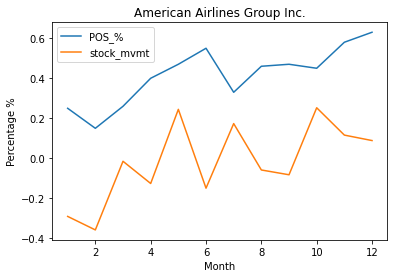

In [119]:
plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

# Companies with best and worst positivity rates

In [550]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word,month,industry,subindustry,ticker_symbol,country,company_relevance
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0.765884,0.667034,0.723726,0.718853,0.685893,0.641455,0.488895,0.729611,0.48086,0.682581,0.523684,0.437137,0.67381,0.648299,0.786551,0.692542,0.646232,0.677501,0.625921,1,Industrials,Machinery,CAT,United States,0.2


In [551]:
df_comp_pos_rate = df_comp[df_comp['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
df_comp_pos_rate

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country
0,Quarterhill Inc.,0,25,25,1.00,QTRH,Canada
1,Avaya Holdings Corp.,0,29,29,1.00,AVYA,United States
2,Karyopharm Therapeutics Inc.,0,35,35,1.00,KPTI,United States
3,"Akoustis Technologies, Inc.",0,26,26,1.00,AKTS,United States
4,Genetic Technologies Limited,0,28,28,1.00,GTG,Australia
...,...,...,...,...,...,...,...
1441,"Ascena Retail Group, Inc.",67,18,85,0.21,ASNA,United States
1442,Westminster Resources Ltd.,28,7,35,0.20,WMR,Canada
1443,Lookers plc,24,6,30,0.20,LOOK,United Kingdom
1444,Flybe Group PLC,102,24,126,0.19,FLYB,United Kingdom


In [552]:
stock_final_min_val = stock_final.copy()
stock_final_min_val = stock_final_min_val[stock_final_min_val["2019-12-01"] >= 1] # remove small value stocks
stock_final_min_val = stock_final_min_val[stock_final_min_val["2020-12-01"] >= 1] # remove small value stocks
print(len(stock_final_min_val))

def is_listed(ticker):
    if (ticker in stock_final_min_val.index):
        if pd.notna(stock_final_min_val.loc[ticker][0]):
            return 1
        else:
            return 0
    else:
        return 0
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]
df_comp_pos_rate_us

3459


roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
15,"Everbridge, Inc.",0,54,54,1.00,EVBG,United States,1
5,Cars.com Inc.,0,38,38,1.00,CARS,United States,1
2,Karyopharm Therapeutics Inc.,0,35,35,1.00,KPTI,United States,1
9,Capstone Turbine Corporation,0,32,32,1.00,CGRN,United States,1
11,"Catalyst Biosciences, Inc.",0,32,32,1.00,CBIO,United States,1
...,...,...,...,...,...,...,...,...
1395,Bishop Capital Corp.,36,20,56,0.36,BPCP,United States,1
1397,"CoreCivic, Inc.",18,10,28,0.36,CXW,United States,1
1402,News Corporation,142,74,216,0.34,NWSA,United States,1
1427,"Republic First Bancorp, Inc.",26,10,36,0.28,FRBK,United States,1


In [ ]:
#df_comp[df_comp['filtered_names_match'] == 'SPX Corporation'].iloc[1]['content']

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
15,"Everbridge, Inc.",0,54,54,1.0,EVBG,United States,1
5,Cars.com Inc.,0,38,38,1.0,CARS,United States,1
2,Karyopharm Therapeutics Inc.,0,35,35,1.0,KPTI,United States,1
9,Capstone Turbine Corporation,0,32,32,1.0,CGRN,United States,1
11,"Catalyst Biosciences, Inc.",0,32,32,1.0,CBIO,United States,1
1,Avaya Holdings Corp.,0,29,29,1.0,AVYA,United States,1
3,"Akoustis Technologies, Inc.",0,26,26,1.0,AKTS,United States,1
6,QAD Inc.,0,26,26,1.0,QADA,United States,1
10,"Commercial Vehicle Group, Inc.",0,26,26,1.0,CVGI,United States,1
13,"BioCryst Pharmaceuticals, Inc.",0,25,25,1.0,BCRX,United States,1


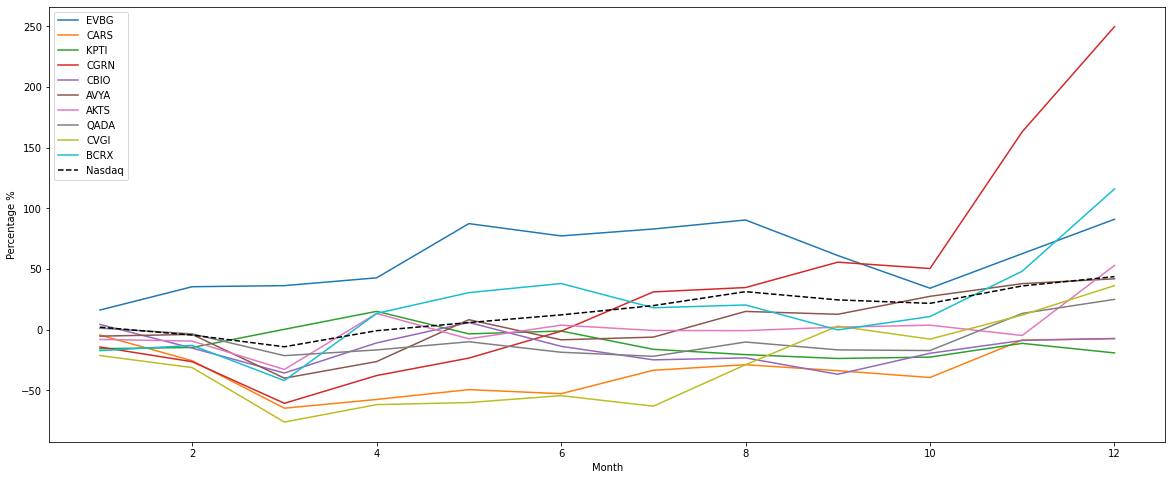

In [554]:
topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
1377,Royal Caribbean Cruises Ltd.,328,209,537,0.39,RCL,United States,1
1378,"United Airlines Holdings, Inc.",920,572,1492,0.38,UAL,United States,1
1385,Southwest Airlines Co.,352,216,568,0.38,LUV,United States,1
1384,Carnival Corporation & Plc,348,213,561,0.38,CCL,United States,1
1392,"Delta Air Lines, Inc.",458,271,729,0.37,DAL,United States,1
1395,Bishop Capital Corp.,36,20,56,0.36,BPCP,United States,1
1397,"CoreCivic, Inc.",18,10,28,0.36,CXW,United States,1
1402,News Corporation,142,74,216,0.34,NWSA,United States,1
1427,"Republic First Bancorp, Inc.",26,10,36,0.28,FRBK,United States,1
1436,Pilgrim's Pride Corporation,20,7,27,0.26,PPC,United States,1


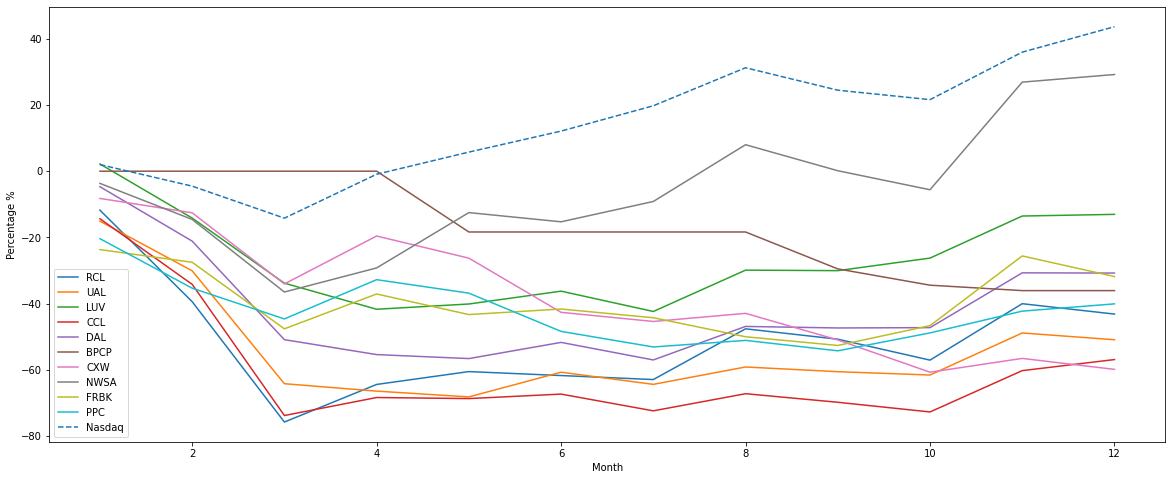

In [555]:
botus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).tail(10)
display(botus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in botus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
6,Eli Lilly and Company,0,83,83,1.00,LLY,United States,1
0,"Sorrento Therapeutics, Inc.",0,57,57,1.00,SRNE,United States,1
2,Amgen Inc.,0,55,55,1.00,AMGN,United States,1
3,Biogen Inc.,0,55,55,1.00,BIIB,United States,1
1,"Novavax, Inc.",0,49,49,1.00,NVAX,United States,1
9,"Humanigen, Inc.",0,29,29,1.00,HGEN,United States,1
5,"Catalyst Biosciences, Inc.",0,27,27,1.00,CBIO,United States,1
11,Bristol-Myers Squibb Company,2,96,98,0.98,BMY,United States,1
10,"Altimmune, Inc.",1,40,41,0.98,ALT,United States,1
15,"Nasdaq, Inc.",13,405,418,0.97,NDAQ,United States,1


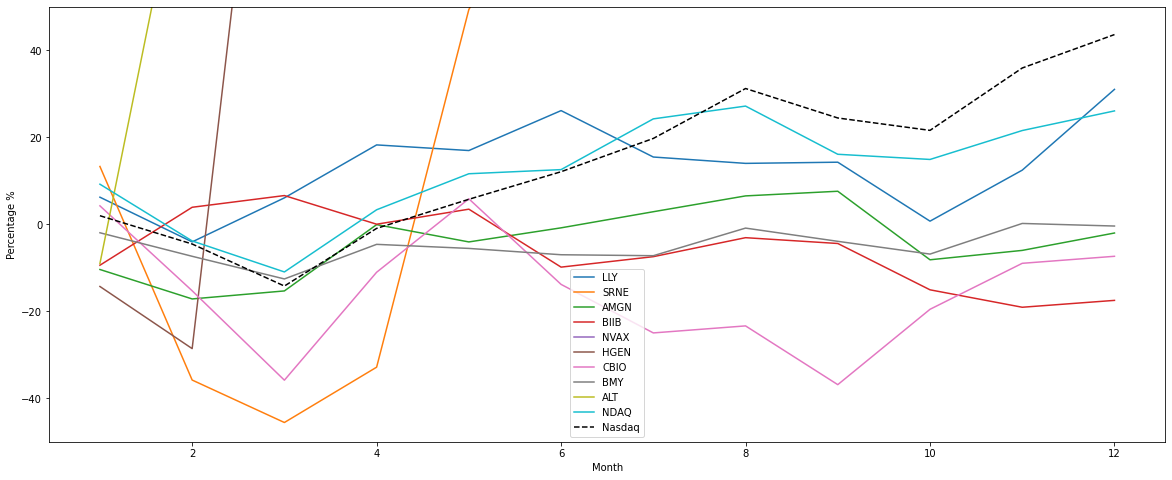

In [556]:
df_topic_selection = df_comp.sort_values('drug_discovery_word')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
0,"Gilead Sciences, Inc.",6,36,42,0.86,GILD,United States,1
1,Pfizer Inc.,41,182,223,0.82,PFE,United States,1
2,Johnson & Johnson,68,226,294,0.77,JNJ,United States,1
4,"Inovio Pharmaceuticals, Inc.",11,31,42,0.74,INO,United States,1
5,"Regeneron Pharmaceuticals, Inc.",12,29,41,0.71,REGN,United States,1
6,"Healthcare Services Group, Inc.",48,101,149,0.68,HCSG,United States,1


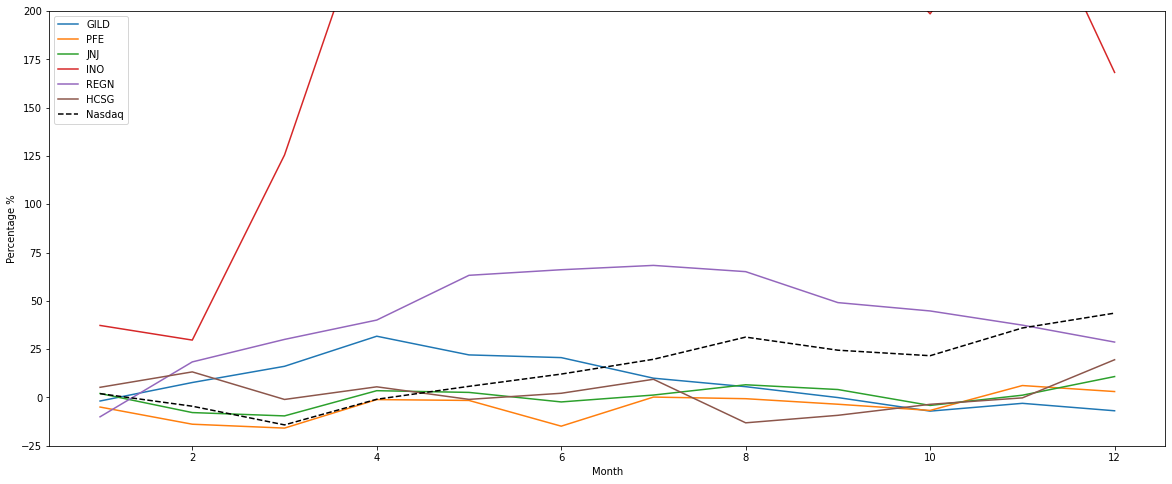

In [562]:
df_topic_selection = df_comp.sort_values('vaccines_word')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-25,200)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
1,"The Goldman Sachs Group, Inc.",4,24,28,0.86,GS,United States,1
3,"Nasdaq, Inc.",7,32,39,0.82,NDAQ,United States,1
4,"Amazon.com, Inc.",18,70,88,0.80,AMZN,United States,1
6,"The Home Depot, Inc.",9,28,37,0.76,HD,United States,1
7,eBay Inc.,15,45,60,0.75,EBAY,United States,1
9,Morgan Stanley,8,22,30,0.73,MS,United States,1
8,Wayfair Inc.,7,19,26,0.73,W,United States,1
12,Target Corporation,81,181,262,0.69,TGT,United States,1
10,Walmart Inc.,47,105,152,0.69,WMT,United States,1
11,"American Eagle Outfitters, Inc.",10,22,32,0.69,AEO,United States,1


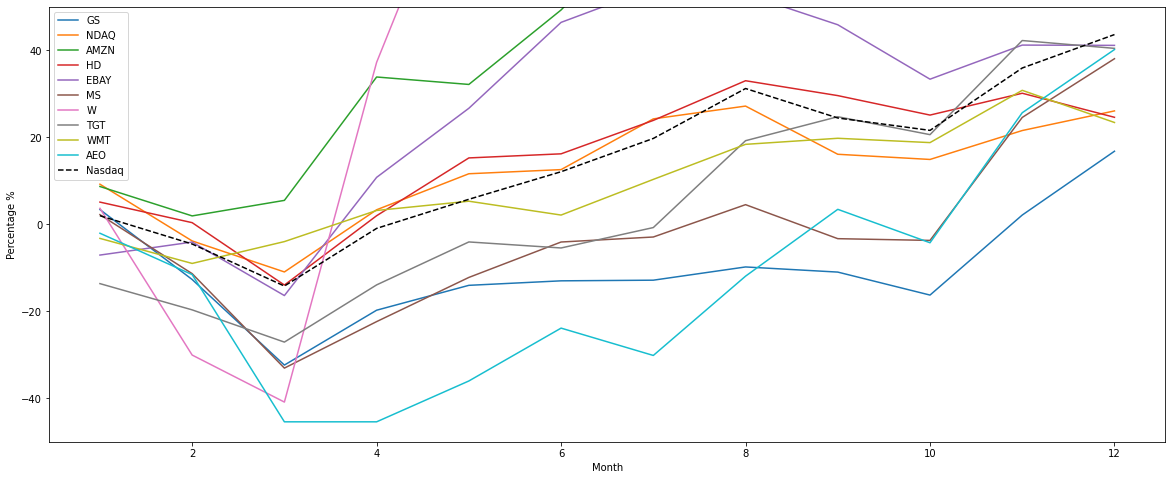

In [558]:
df_topic_selection = df_comp.sort_values('store_closure')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
1,"The PNC Financial Services Group, Inc.",16,21,37,0.57,PNC,United States,1
0,McDonald's Corporation,13,17,30,0.57,MCD,United States,1
5,The Boeing Company,47,34,81,0.42,BA,United States,1
6,American Airlines Group Inc.,30,22,52,0.42,AAL,United States,1
7,Apple Inc.,51,34,85,0.40,AAPL,United States,1
8,"United Airlines Holdings, Inc.",39,21,60,0.35,UAL,United States,1
9,"Nasdaq, Inc.",67,35,102,0.34,NDAQ,United States,1
12,Bank of America Corporation,26,13,39,0.33,BAC,United States,1
13,Dow Inc.,86,41,127,0.32,DOW,United States,1
15,"The Goldman Sachs Group, Inc.",73,24,97,0.25,GS,United States,1


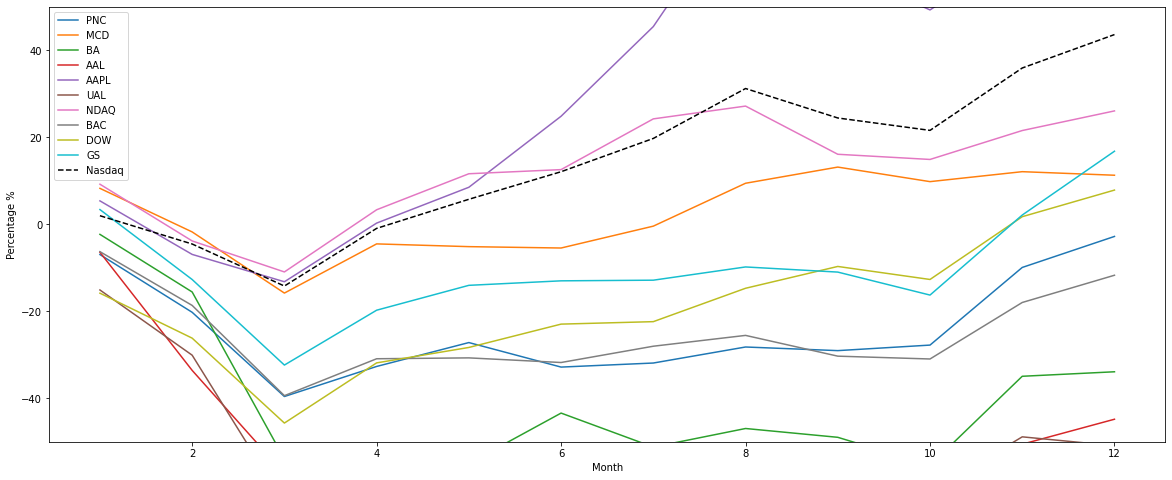

In [559]:
df_topic_selection = df_comp.sort_values('shutdown')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,country,listed
2,General Electric Company,0,55,55,1.00,GE,United States,1
3,International Business Machines Corporation,0,51,51,1.00,IBM,United States,1
5,Oracle Corporation,0,50,50,1.00,ORCL,United States,1
0,3M Company,0,48,48,1.00,MMM,United States,1
4,Johnson & Johnson,0,38,38,1.00,JNJ,United States,1
6,The Procter & Gamble Company,0,30,30,1.00,PG,United States,1
1,Apple Inc.,0,26,26,1.00,AAPL,United States,1
8,Microsoft Corporation,1,63,64,0.98,MSFT,United States,1
9,Honeywell International Inc.,2,75,77,0.97,HON,United States,1
11,"Healthcare Services Group, Inc.",2,54,56,0.96,HCSG,United States,1


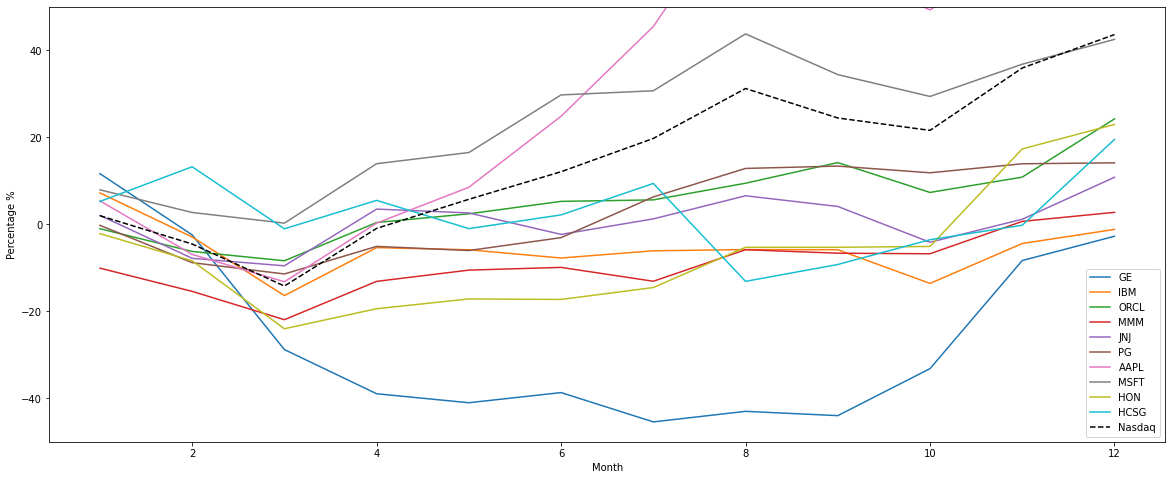

In [560]:
df_topic_selection = df_comp.sort_values('diversification')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

# End

In [68]:
df_combined[df_combined['content_processed'].str.contains('telehealth')]

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,blockchain_word,digitization_word,machine_learne_word,cloud_word,iot_word,store_closure_word,delivery_word,redundancy_word,costcutte_word,flight_word,supply_chain_word,shutdown_word,outsourcing_word,workfromhome_word,diversification_word,vaccines_word,drug_discovery_word,tele_health_word,cybersecurity_word,nb_comp_0
6375,NaN,2020-02-20,finance.yahoo,Coronavirus' biggest winners: Tech providers i...,https://finance.yahoo.com/news/technology-use-...,"The coronavirus outbreak is roiling China, but...",business,coronavirus outbreak roiling china startup tec...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,224,"[finance, tele_health]",finance_tele_health,0.512150,"[telehealth, telemedicine, teladoc, medicare, ...",finance,[Apple Inc.],[],1,0,0.645065,0.448590,0.511541,0.547363,0.476138,0.460042,0.203583,0.581515,0.238566,0.516076,0.253257,0.165389,0.470721,0.424939,0.661180,0.772644,0.646790,0.687114,0.710060,0.664437,0.654126,0.489849,0.731936,0.512258,0.690019,0.521668,0.465384,0.660966,0.631641,0.782966,0.670135,0.619374,0.625641,0.601382,0
7495,Josh Nathan-Kazis,2020-02-25,marketwatch,"Coronavirus Will Spread Within the U.S., CDC O...",https://www.marketwatch.com/articles/coronavir...,The CDC warned Tuesday that the novel coronavi...,business,cdc warned tuesday novel coronavirus spread yo...,NEGATIVE,NEUTRAL,NEGATIVE,False,NEGATIVE,397,"[covid, us, task_force]",covid_us_task_force,0.393804,"[navarro, azar, task_force, mike_pence, downpl...",covid,[],[],0,0,0.696329,0.552060,0.578489,0.626855,0.566877,0.499628,0.248153,0.595769,0.242033,0.507382,0.285354,0.142909,0.550190,0.470596,0.726467,0.792879,0.694480,0.712506,0.745494,0.704586,0.658718,0.487198,0.724292,0.483023,0.664007,0.512571,0.415415,0.693204,0.638916,0.813435,0.610948,0.623588,0.604369,0.615244,1
7627,"Eliott C. McLaughlin and Steve Almasy, CNN",2020-02-25,cnn,CDC official warns Americans it's not a questi...,https://www.cnn.com/2020/02/25/health/coronavi...,One of the top officials at the Centers for D...,general,officials centers disease control prevention w...,NEGATIVE,NEUTRAL,NEGATIVE,False,NEGATIVE,481,"[covid, covid_emerging, human_transmission]",covid_covid_emerging_human_transmission,0.487246,"[humantohuman, coronaviruse, sar, flulike, inc...",covid,[],[],0,0,0.690461,0.554998,0.571175,0.629313,0.564044,0.516817,0.253032,0.601141,0.254582,0.496908,0.296873,0.159104,0.554361,0.481138,0.727471,0.793477,0.703096,0.713889,0.752679,0.709132,0.677621,0.501625,0.733882,0.502659,0.664339,0.530876,0.438957,0.702671,0.653817,0.818170,0.619852,0.619117,0.616203,0.620641,1
7706,Berkeley Lovelace Jr.@BerkeleyJrWilliam Feuer@...,2020-02-25,cnbc,"CDC outlines what closing schools, businesses ...",https://www.cnbc.com/2020/02/25/cdc-outlines-w...,The Centers for Disease Control and Prevention...,finance,centers disease control prevention stepped tue...,NEGATIVE,NEUTRAL,POSITIVE,False,NEGATIVE,780,"[covid, covid_emerging]",covid_covid_emerging,0.531715,"[ghebreyesus, tedro, directorgeneral, geneva, ...",covid,[],[],0,0,0.708347,0.575218,0.598741,0.641192,0.584647,0.515332,0.262747,0.598043,0.250294,0.474367,0.301006,0.144356,0.567727,0.485951,0.751067,0.801642,0.711100,0.727098,0.755969,0.717512,0.670371,0.498584,0.726623,0.490114,0.642510,0.524604,0.418064,0.706005,0.650388,0.830697,0.599891,0.637356,0.610354,0.624540,1
7773,"Megan Thielking,STAT",2020-02-25,scientificamerican,CDC Expects Community Spread of Coronavirus in...,https://www.scientificamerican.com/article/cdc...,The Centers for Disease Control and Prevention...,science,centers disease 